<a href="https://colab.research.google.com/github/GiulianoFassano/prueba-DT/blob/master/Fassano_Giuliano_PT_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [938]:
import numpy as np
import pandas as pd
import pylab as plt
from google.colab import drive
from scipy.optimize import curve_fit

import matplotlib.ticker as ticker
import datetime
import seaborn as sns
from IPython.display import clear_output 

from sklearn.linear_model import LinearRegression
## Importo las funciones de accuracy y testeo de modelos:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
## Importo los modelos que voy a usar/probar:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
## Librerías de optimización de modelos:
from sklearn.model_selection import RandomizedSearchCV

In [939]:
#cargamos los datos

drive.mount('/content/gdrive', force_remount=True)

# Aca deben apuntar a la carpeta de su drive donde guardaron los datos
root_dir = '/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 4/cumulative-deaths-and-cases-covid-19.csv'


Mounted at /content/gdrive


In [940]:
datos=pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 4/cumulative-deaths-and-cases-covid-19.csv')
datos

,Entity,Code,Day,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19
0,Afghanistan,AFG,2020-03-23,1.0000,40.0000
1,Afghanistan,AFG,2020-03-24,1.0000,42.0000
2,Afghanistan,AFG,2020-03-25,1.0000,74.0000
3,Afghanistan,AFG,2020-03-26,2.0000,80.0000
4,Afghanistan,AFG,2020-03-27,2.0000,91.0000
...,...,...,...,...,...
152429,Zimbabwe,ZWE,2022-01-02,5017.0000,214214.0000
152430,Zimbabwe,ZWE,2022-01-03,5047.0000,216087.0000
152431,Zimbabwe,ZWE,2020-03-20,NaN,1.0000
152432,Zimbabwe,ZWE,2020-03-21,NaN,3.0000


Vamos a elegir 10 países:

- Estados Unidos
- Francia
- Canada
- España
- India
- Rusia
- Korea del Sur
- Japon 
- Ucrania
- Argentina


Además, sólo elijo las columnas que me interesan y le hago cambio de nombre

- Locación (País)
- Fecha
- Total de casos: total_cases: Total confirmed cases of COVID-19. Counts can include probable cases, where reported.
- Nuevos Casos: new_cases: New confirmed cases of COVID-19. Counts can include probable cases, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA.
- Total de muertes: total_deaths: Total deaths attributed to COVID-19. Counts can include probable deaths, where reported.


In [941]:
# Cambio los nombres a las columnas que voy a usar
datos.rename(columns = {'Entity':'pais'}, inplace = True) 
datos.rename(columns = {'Day':'fecha'}, inplace = True) 
datos.rename(columns = {'Total confirmed cases of COVID-19'	:'casos_totales'}, inplace = True)  
datos.rename(columns = {'Total confirmed deaths due to COVID-19'	:'muertes_totales'}, inplace = True) 
datos.head()

,pais,Code,fecha,muertes_totales,casos_totales
0,Afghanistan,AFG,2020-03-23,1.0000,40.0000
1,Afghanistan,AFG,2020-03-24,1.0000,42.0000
2,Afghanistan,AFG,2020-03-25,1.0000,74.0000
3,Afghanistan,AFG,2020-03-26,2.0000,80.0000
4,Afghanistan,AFG,2020-03-27,2.0000,91.0000


In [942]:
datos = datos[['pais', 'fecha','casos_totales', 'muertes_totales']].copy()

datos

,pais,fecha,casos_totales,muertes_totales
0,Afghanistan,2020-03-23,40.0000,1.0000
1,Afghanistan,2020-03-24,42.0000,1.0000
2,Afghanistan,2020-03-25,74.0000,1.0000
3,Afghanistan,2020-03-26,80.0000,2.0000
4,Afghanistan,2020-03-27,91.0000,2.0000
...,...,...,...,...
152429,Zimbabwe,2022-01-02,214214.0000,5017.0000
152430,Zimbabwe,2022-01-03,216087.0000,5047.0000
152431,Zimbabwe,2020-03-20,1.0000,NaN
152432,Zimbabwe,2020-03-21,3.0000,NaN


In [943]:
# Paso a formato de fecha la columna fecha
datos['fecha'] = pd.to_datetime(datos.fecha)

In [944]:
# Analizo que paises hay en el dataset
datos.pais.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Asia excl. China', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire Sint Eustatius and Saba', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia

In [945]:
# Cambio los nombres de los paises
datos['pais'] = datos['pais'].map({'United States':'Estados Unidos',
                             'France':'Francia',
                             'Canada':'Canada',
                             'Spain':'España',
                             'India':'India',
                             'Russia':'Rusia',
                             'South Korea':'Korea del Sur',
                             'Japan':'Japon',
                             'Ukraine':'Ucrania',
                             'Argentina':'Argentina'})

In [946]:
datos = datos.dropna(subset=["pais"]) #simplemente elimino los países que no me interesan de una forma más fácil.

In [947]:
datos

,pais,fecha,casos_totales,muertes_totales
5352,Argentina,2020-03-08,12.0000,1.0000
5353,Argentina,2020-03-09,12.0000,1.0000
5354,Argentina,2020-03-10,17.0000,1.0000
5355,Argentina,2020-03-11,19.0000,1.0000
5356,Argentina,2020-03-12,19.0000,1.0000
...,...,...,...,...
142692,Estados Unidos,2020-02-24,16.0000,NaN
142693,Estados Unidos,2020-02-25,16.0000,NaN
142694,Estados Unidos,2020-02-26,16.0000,NaN
142695,Estados Unidos,2020-02-27,17.0000,NaN


In [948]:
datos = datos.reset_index(drop=True)

In [949]:
datos

,pais,fecha,casos_totales,muertes_totales
0,Argentina,2020-03-08,12.0000,1.0000
1,Argentina,2020-03-09,12.0000,1.0000
2,Argentina,2020-03-10,17.0000,1.0000
3,Argentina,2020-03-11,19.0000,1.0000
4,Argentina,2020-03-12,19.0000,1.0000
...,...,...,...,...
7010,Estados Unidos,2020-02-24,16.0000,NaN
7011,Estados Unidos,2020-02-25,16.0000,NaN
7012,Estados Unidos,2020-02-26,16.0000,NaN
7013,Estados Unidos,2020-02-27,17.0000,NaN


In [950]:
datos.describe()

,casos_totales,muertes_totales
count,7015.0000,6726.0000
mean,5089391.1879,94589.7394
std,9816419.3289,157128.5152
min,1.0000,1.0000
25%,132402.0000,4708.0000
50%,1364195.0000,29895.5000
75%,4929546.0000,106479.2500
max,56189547.0000,827748.0000


In [951]:
datos.groupby("pais").size()

pais
Argentina         672
Canada            709
España            703
Estados Unidos    713
Francia           711
India             705
Japon             713
Korea del Sur     713
Rusia             704
Ucrania           672
dtype: int64

In [952]:
paises=datos['pais'] #cargo el vector de paises
confirmados=datos['casos_totales'] #carga vector todos los casos confirmados

Text(0.5, 0, 'dias')

Text(0, 0.5, 'cantidad de casos')

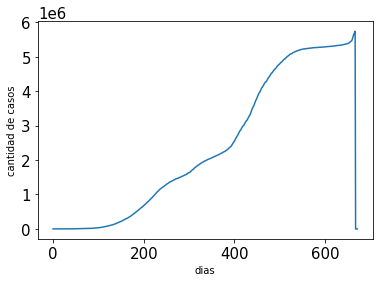

In [953]:
#seleccionamos Argentina

ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias= np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0.5, 0, 'dias')

Text(0, 0.5, 'log cantidad de casos')

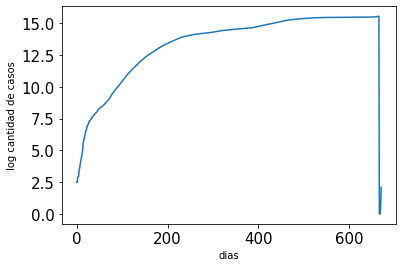

In [954]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

Text(0.5, 0, 'dias')

Text(0, 0.5, 'cantidad de casos')

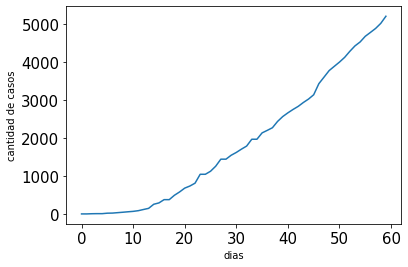

In [955]:
casos_principio= casos_arg[0:60]
dias_principio= dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0.5, 0, 'dias')

Text(0, 0.5, 'log cantidad de casos')

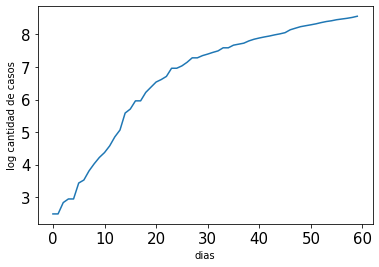

In [956]:

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 31 y 55, ya que ese fue el comportamiento más sostenido.

Text(0.5, 0, 'dias')

Text(0, 0.5, 'cantidad de casos')

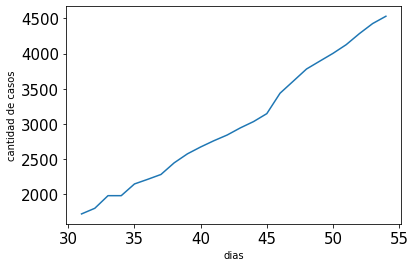

In [957]:
casos_principio=casos_arg[31:55]
dias_principio=dias[31:55]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0.5, 0, 'dias')

Text(0, 0.5, 'log cantidad de casos')

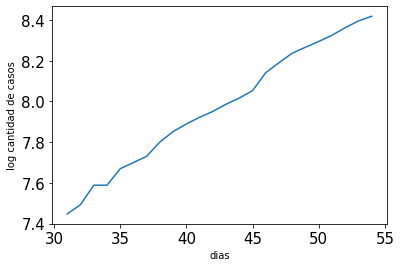

In [958]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [959]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [960]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 4.14022703e-02, -1.50098621e+02])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

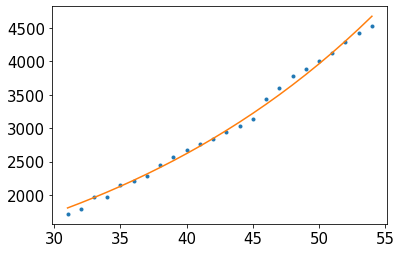

In [961]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

# PARTE 1

Armo un gráfico que muestre la cantidad de casos en cada país elegido

In [962]:
if 'Unnamed: 0' in datos.columns:
  dataset.drop(columns=['Unnamed: 0'],inplace=True)

In [963]:
datos

,pais,fecha,casos_totales,muertes_totales
0,Argentina,2020-03-08,12.0000,1.0000
1,Argentina,2020-03-09,12.0000,1.0000
2,Argentina,2020-03-10,17.0000,1.0000
3,Argentina,2020-03-11,19.0000,1.0000
4,Argentina,2020-03-12,19.0000,1.0000
...,...,...,...,...
7010,Estados Unidos,2020-02-24,16.0000,NaN
7011,Estados Unidos,2020-02-25,16.0000,NaN
7012,Estados Unidos,2020-02-26,16.0000,NaN
7013,Estados Unidos,2020-02-27,17.0000,NaN


In [964]:
#repasamos los países elegidos en el dataset

datos.pais.unique()

array(['Argentina', 'Canada', 'Francia', 'India', 'Japon', 'Rusia',
       'Korea del Sur', 'España', 'Ucrania', 'Estados Unidos'],
      dtype=object)

In [965]:
paises = ['Argentina', 'Canada', 'Francia', 'India', 'Japon', 'Rusia',
       'Korea del Sur', 'España', 'Ucrania', 'Estados Unidos']


<Figure size 1280x960 with 0 Axes>

Text(0.5, 1.0, 'Total de Casos')

Text(0, 0.5, 'Total de casos')

Text(0.5, 0, 'Días transcurridos')

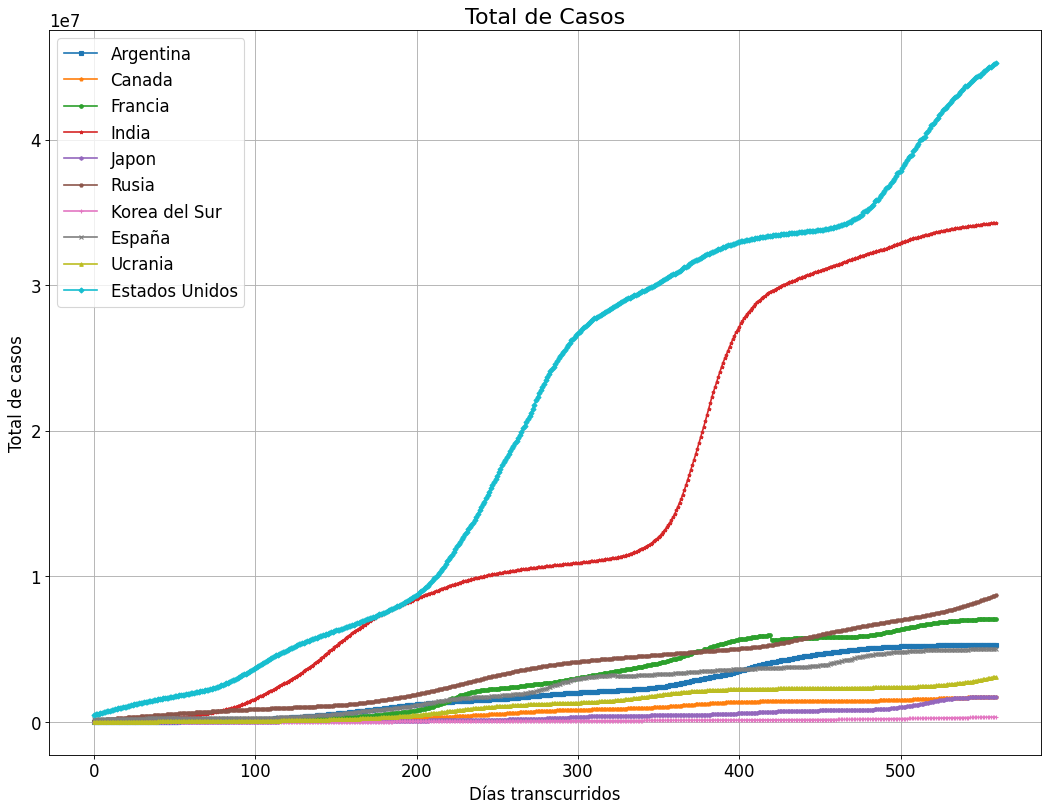

In [966]:
# Grafico los casos para cada país por día.
i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ['s','p','o','*','h','H','+','x','^','D','.','*']

for pais in paises:
   casos_pais = datos['casos_totales'][(datos.pais == pais)][40:600]
   dias = np.arange(casos_pais.shape[0]) 
   plt.plot(dias,casos_pais,label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Total de Casos', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total de casos', fontsize = 15)
plt.xlabel('Días transcurridos', fontsize = 15)
plt.grid()
plt.show()

<Figure size 1280x960 with 0 Axes>

Text(0.5, 1.0, 'Total de Casos')

Text(0, 0.5, 'Total de casos escala logaritmica')

Text(0.5, 0, 'Días transcurridos')

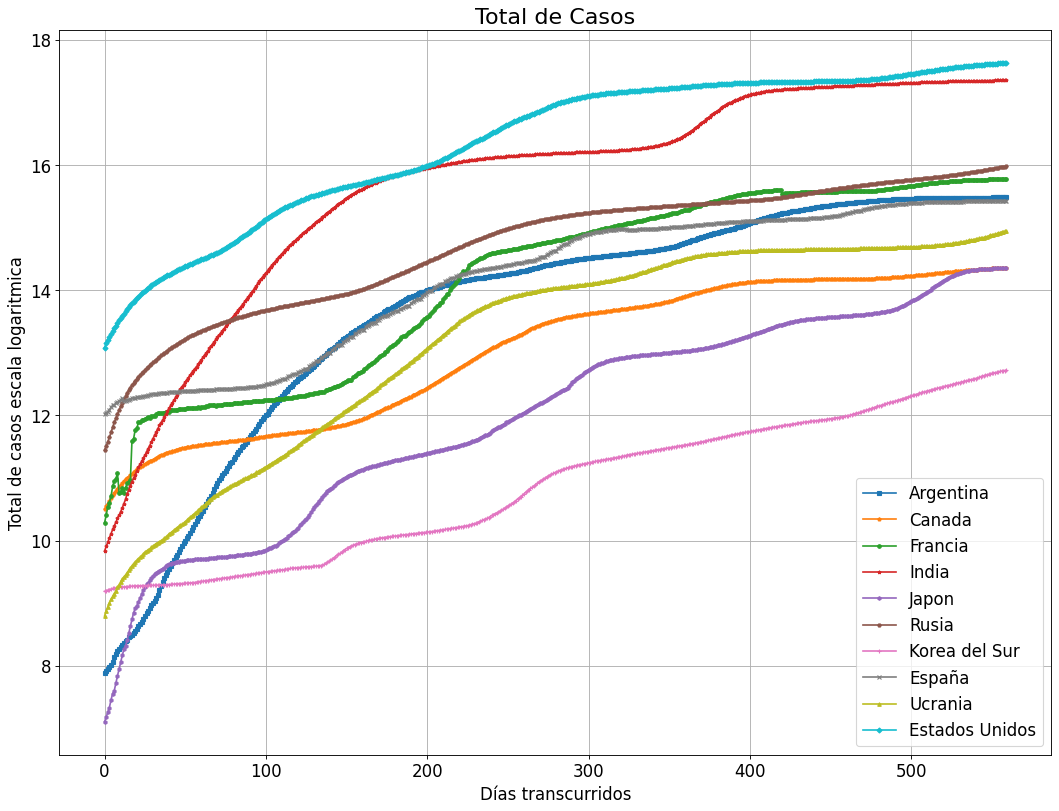

In [967]:
# Grafico los casos para cada país por día. En escala logaritmica
i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ['s','p','o','*','h','H','+','x','^','D','.','*']

for pais in paises:
   casos_pais = datos['casos_totales'][(datos.pais == pais)][40:600]
   dias = np.arange(casos_pais.shape[0]) 
   plt.plot(dias,np.log(casos_pais),label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Total de Casos', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total de casos escala logaritmica', fontsize = 15)
plt.xlabel('Días transcurridos', fontsize = 15)
plt.grid()
plt.show()

(array([737516., 737607., 737699., 737791., 737881., 737972., 738064.,
        738156.]), <a list of 8 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

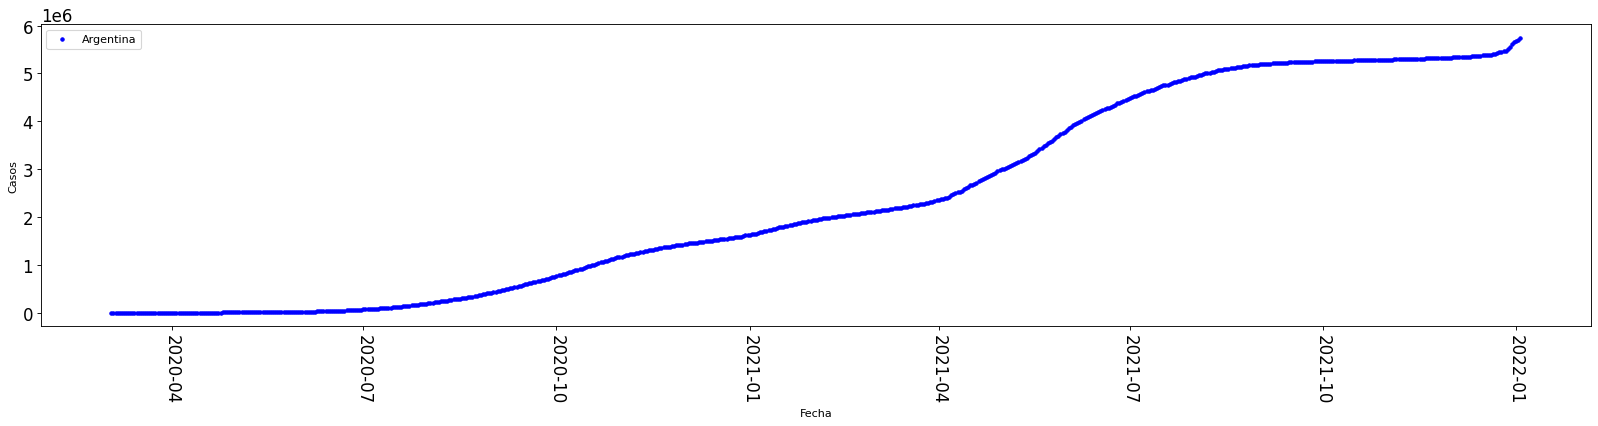

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

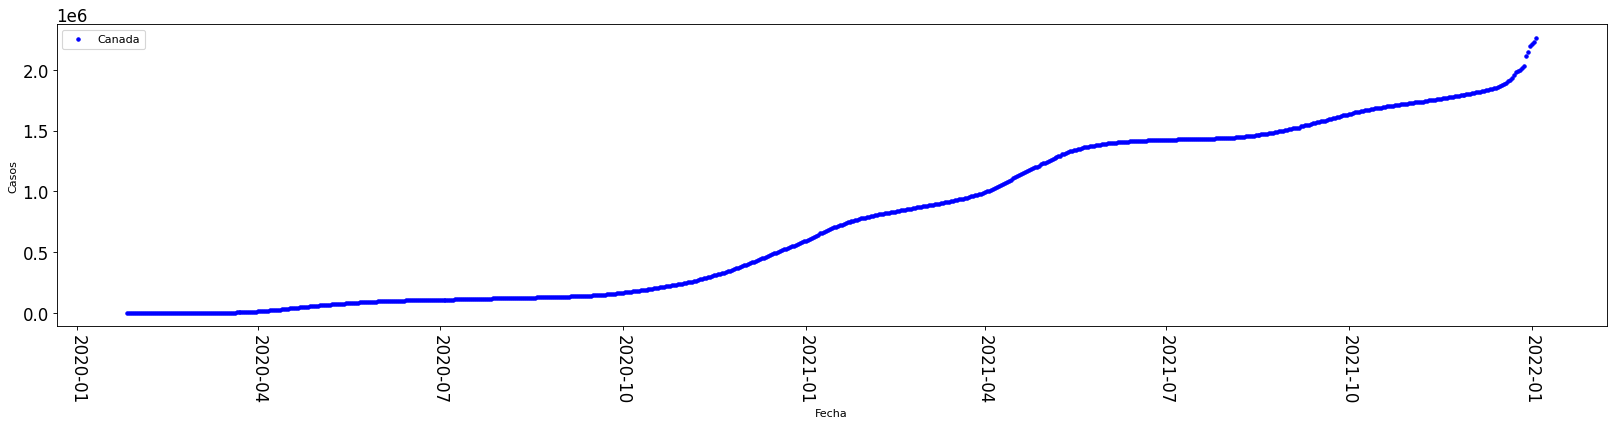

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

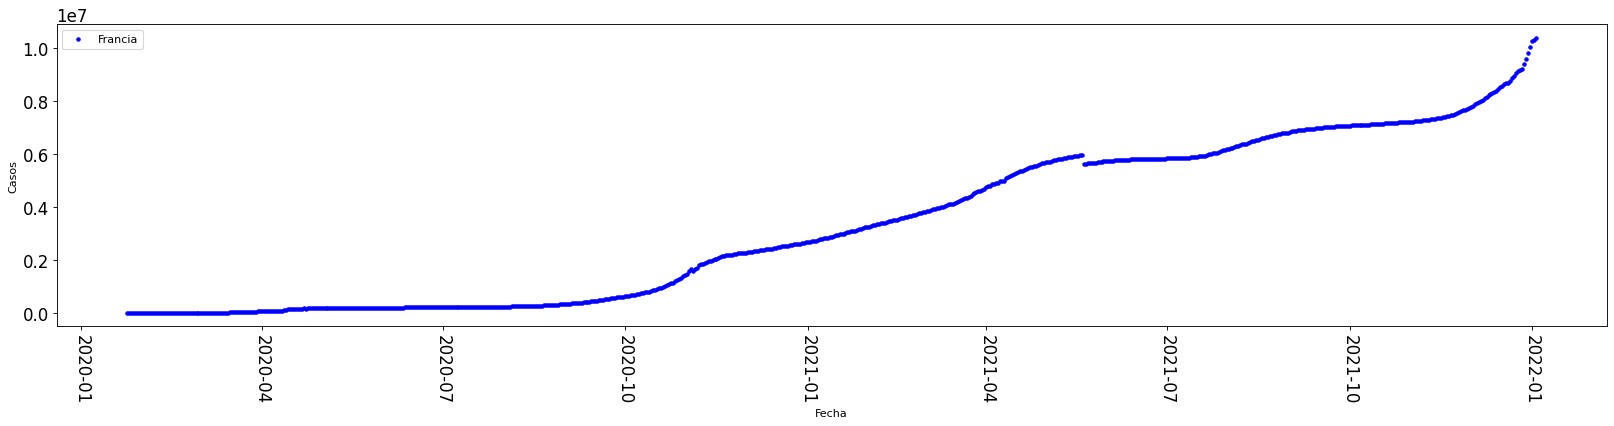

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

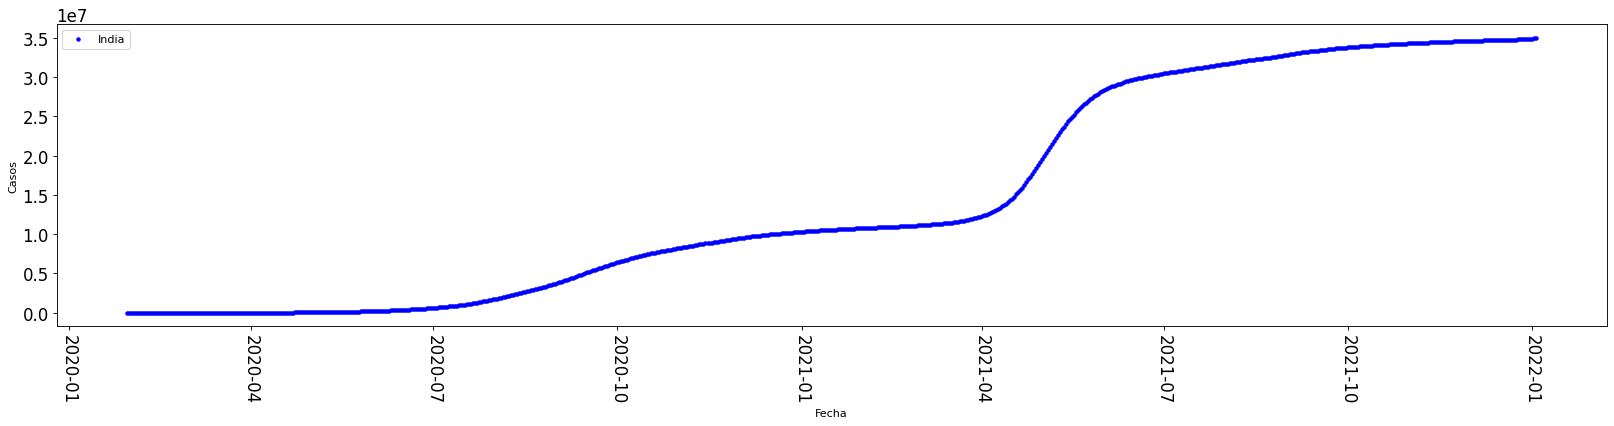

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

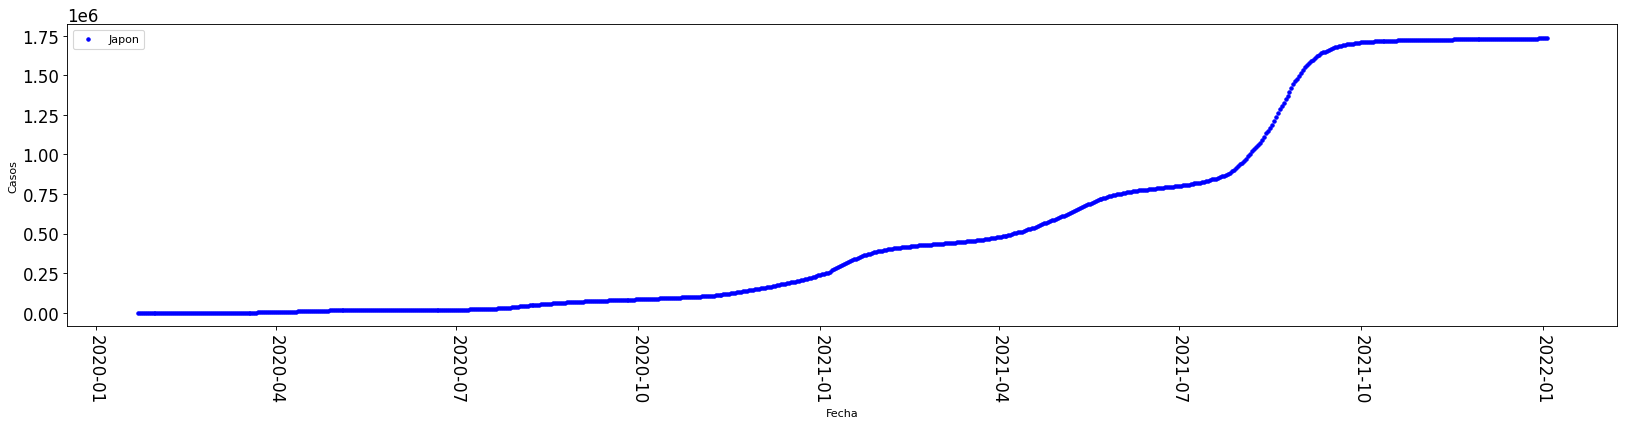

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

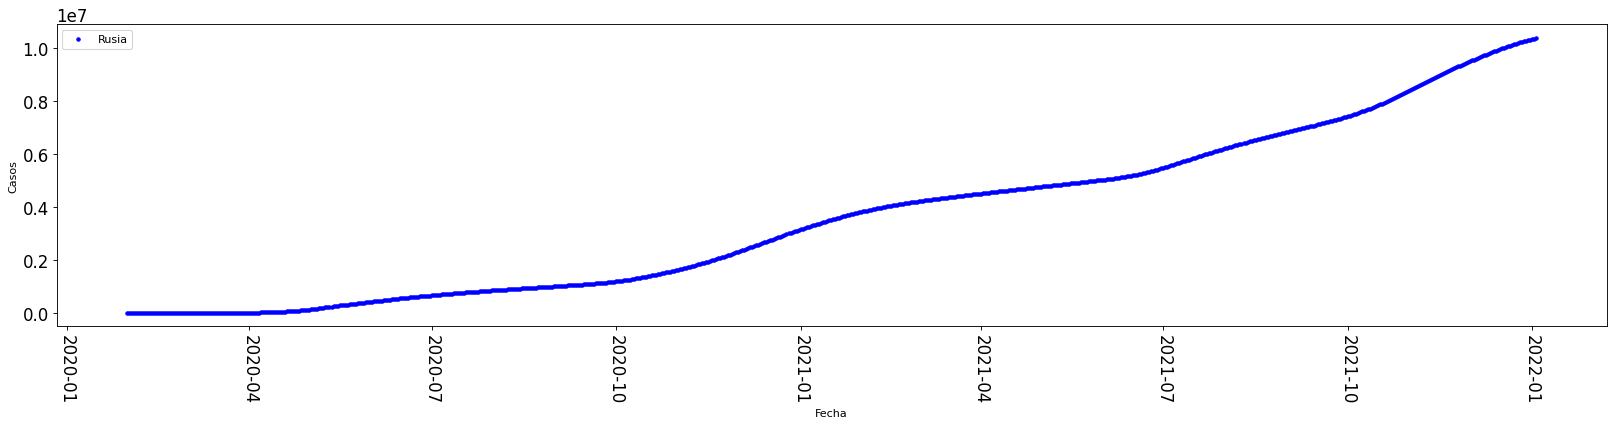

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

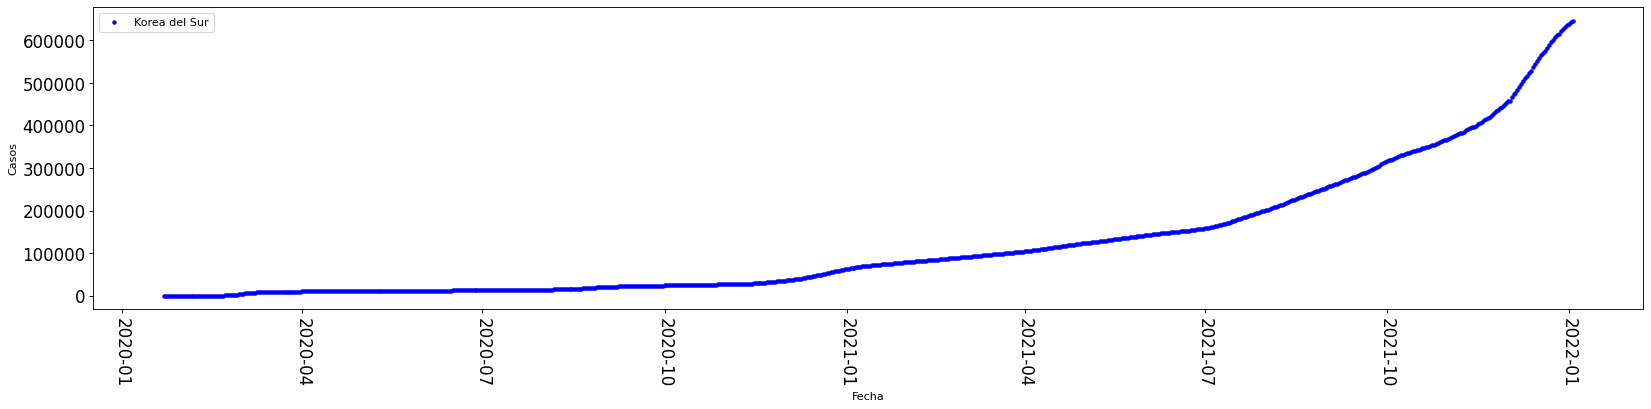

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

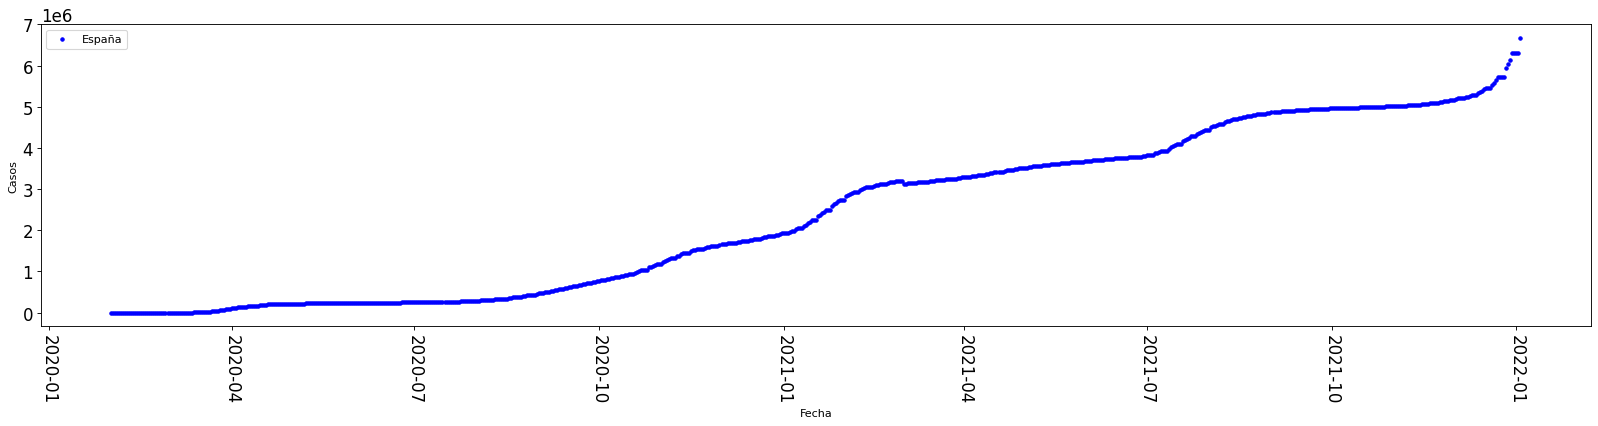

(array([737516., 737607., 737699., 737791., 737881., 737972., 738064.,
        738156.]), <a list of 8 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

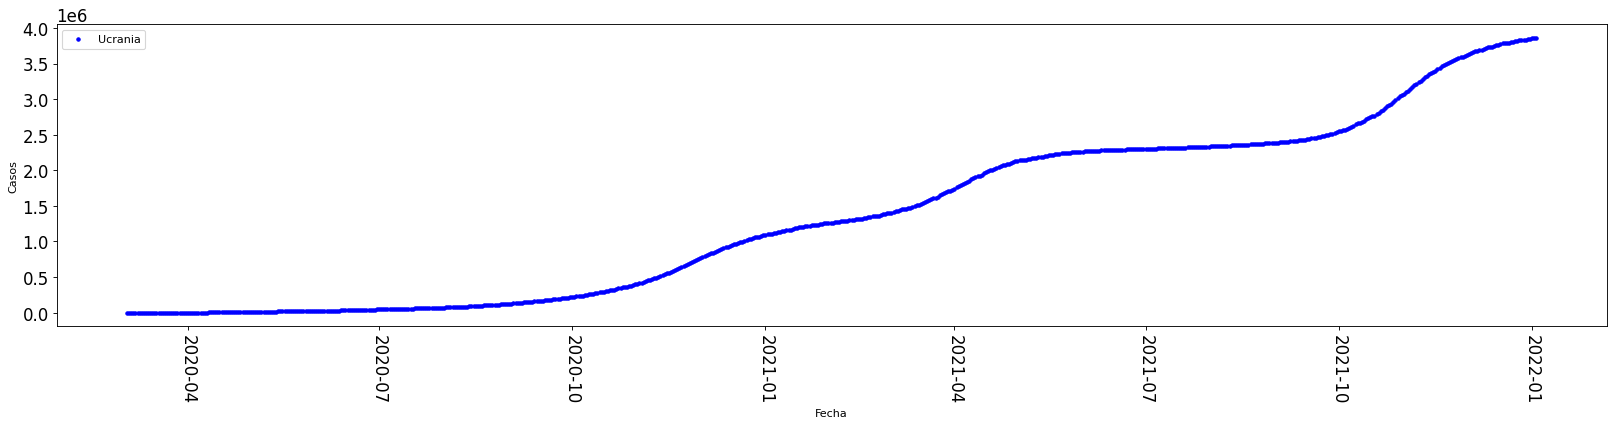

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

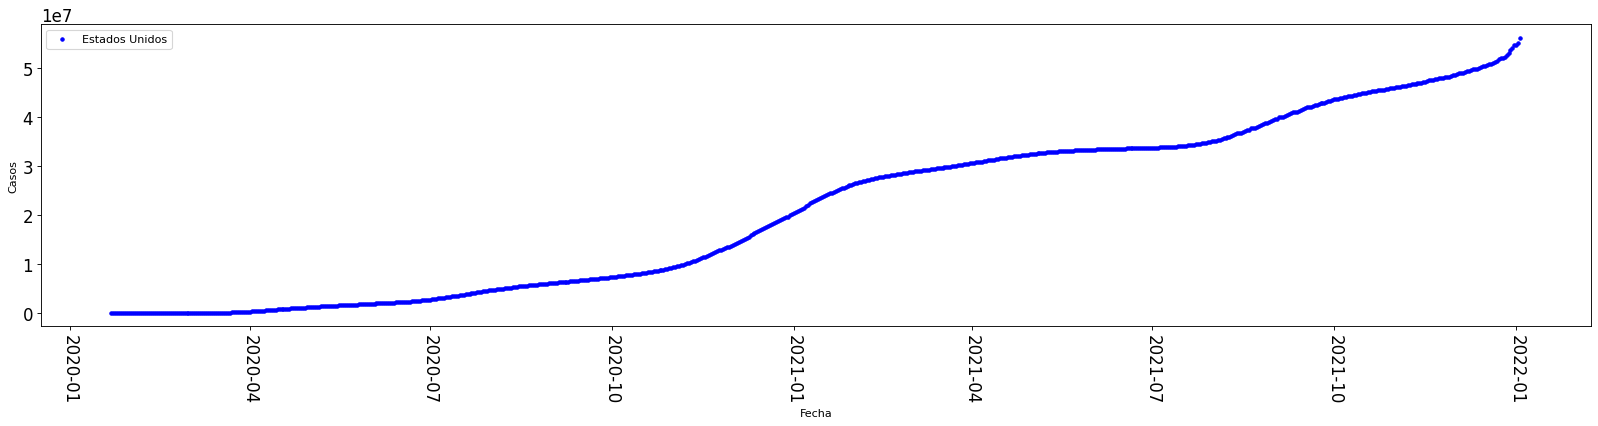

In [968]:
# Grafico cada uno para comprender mejor cada momento de cada uno

paises = ['Argentina', 'Canada', 'Francia', 'India', 'Japon', 'Rusia',
       'Korea del Sur', 'España', 'Ucrania', 'Estados Unidos']
for i in paises:
  fig,ax = plt.subplots(figsize=(25,5), dpi= 80)
  mask = (datos.loc[:,'pais'] == i ) 
  datosgraf = datos[mask]
  # dias = np.arange(datos_aux.shape[0]) por si lo quiero ver en días, cambio la variable en la siguiente línea de código por "dias"
  plt.plot(datosgraf.fecha, datosgraf.casos_totales, 'b.', label = i)    
  plt.xticks(rotation=-90)
  plt.xlabel('Fecha')
  plt.ylabel('Casos')
  plt.legend()
  plt.show()

(array([737485., 737516., 737546., 737577., 737607., 737638., 737669.,
        737699., 737730., 737760.]),
 <a list of 10 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

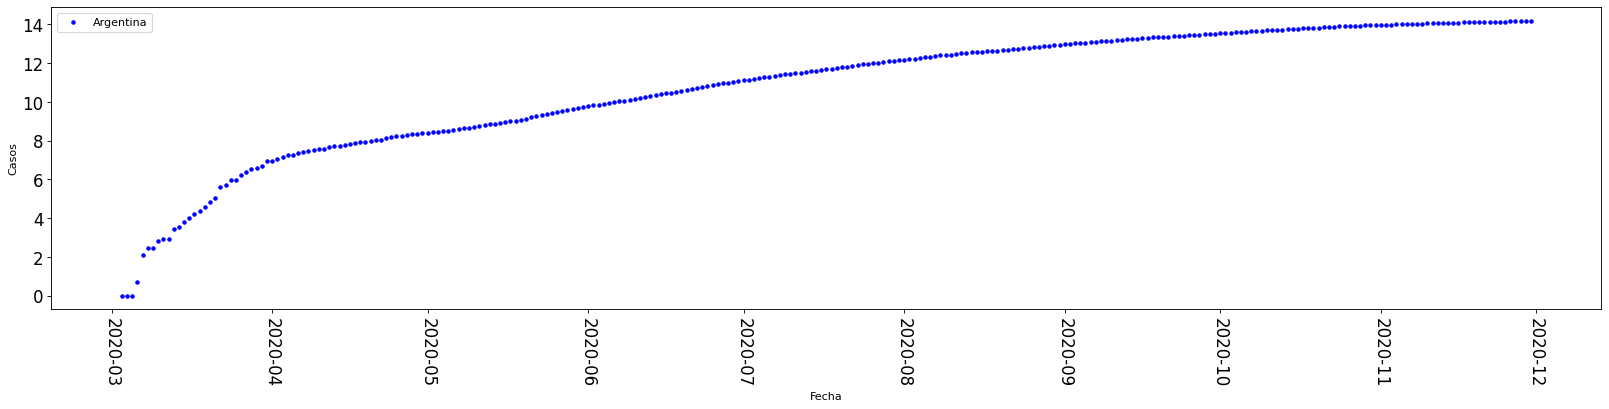

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

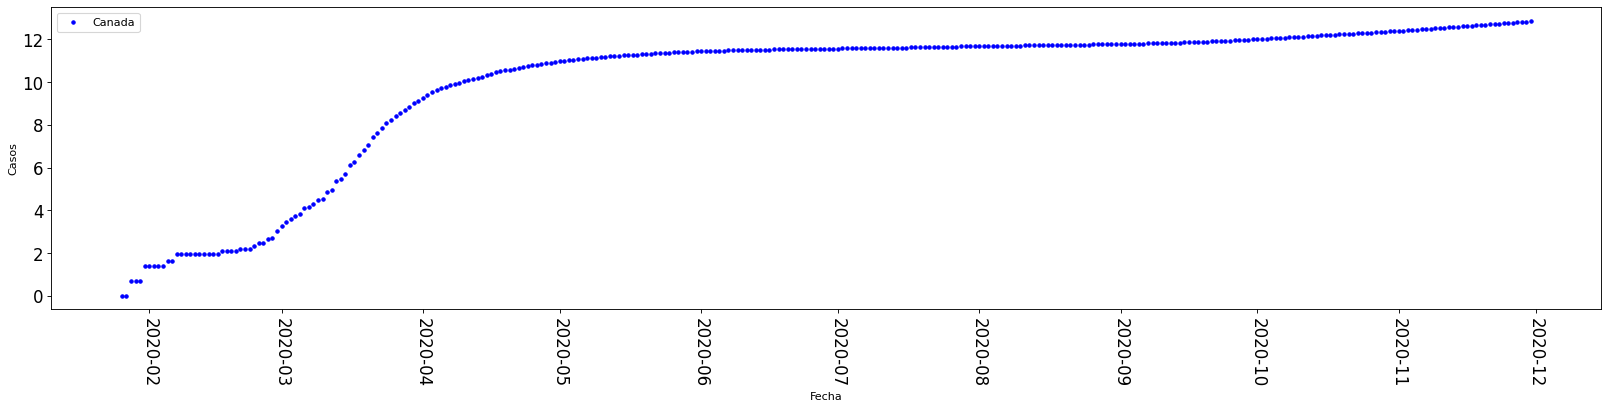

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

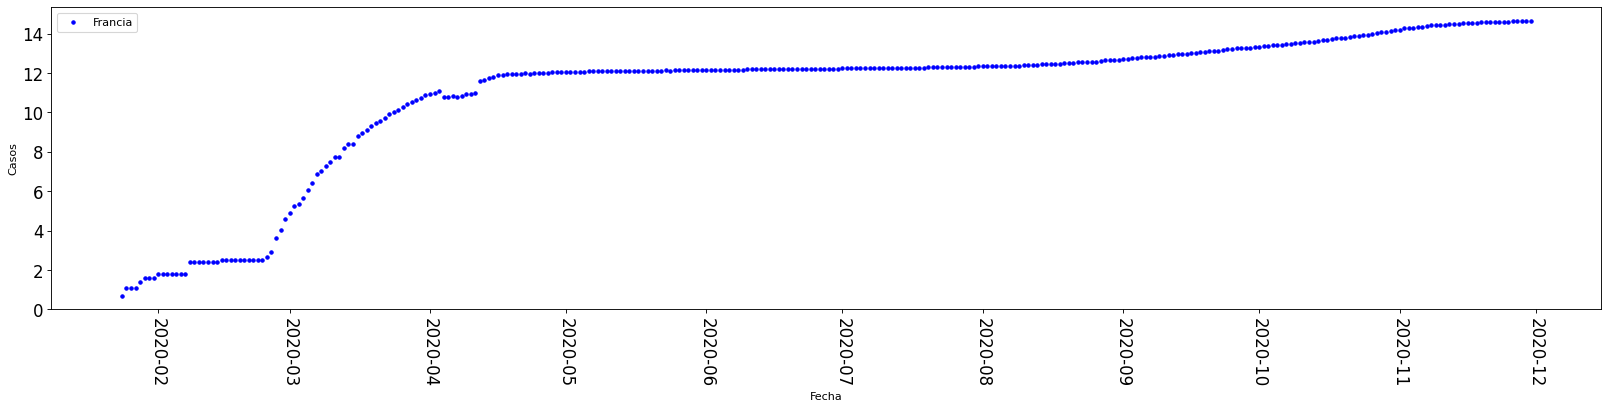

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

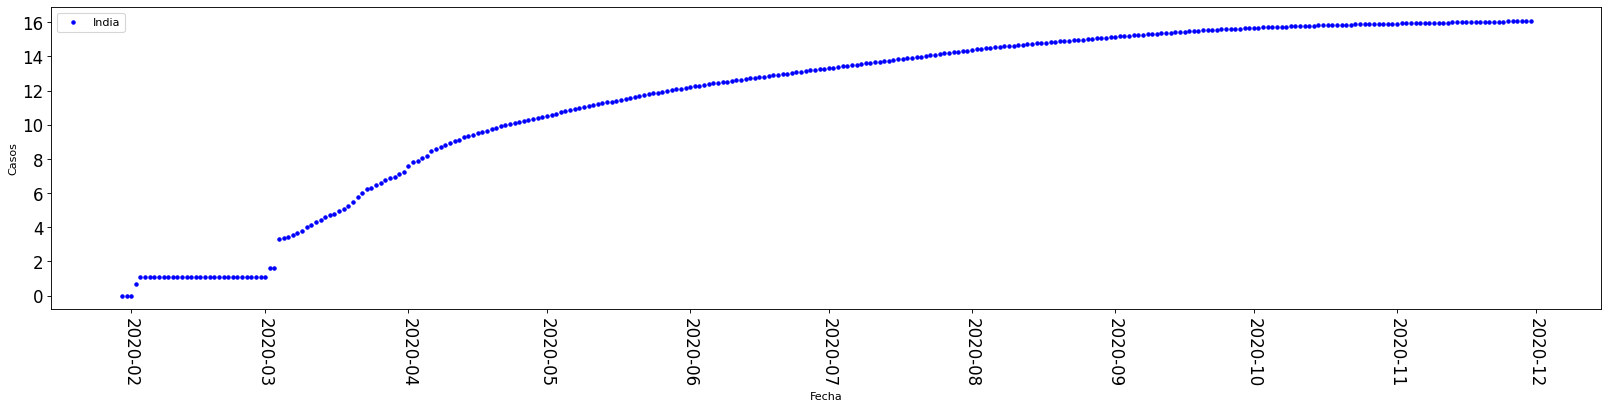

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

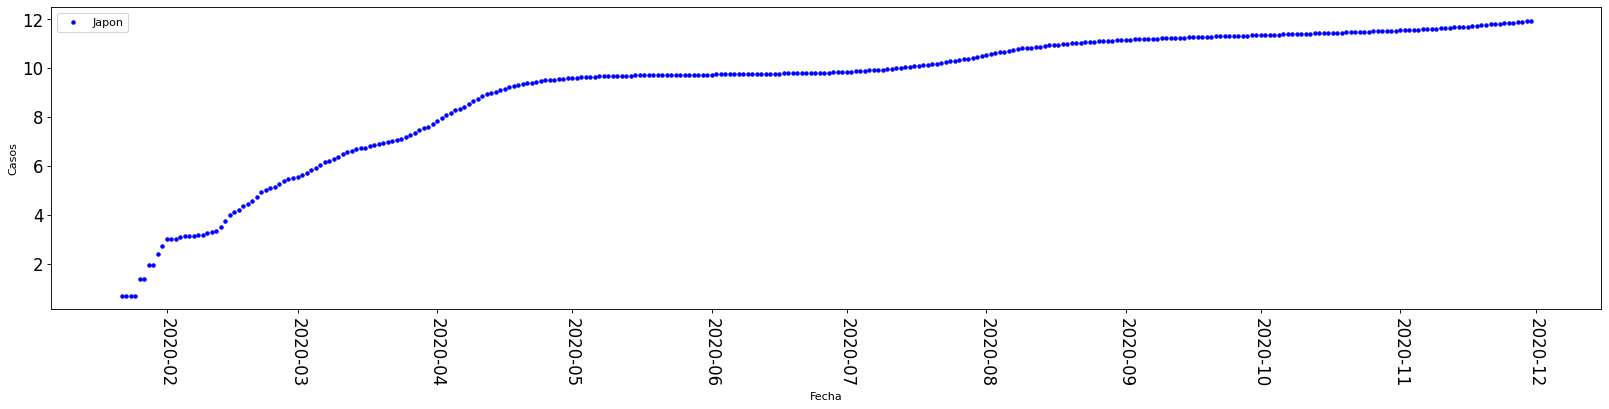

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

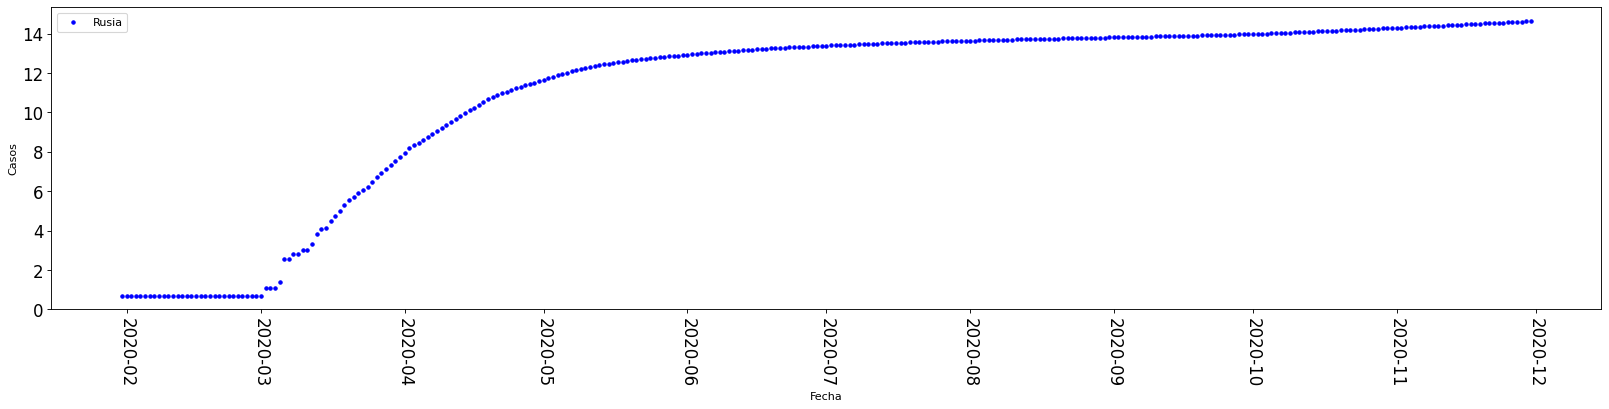

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

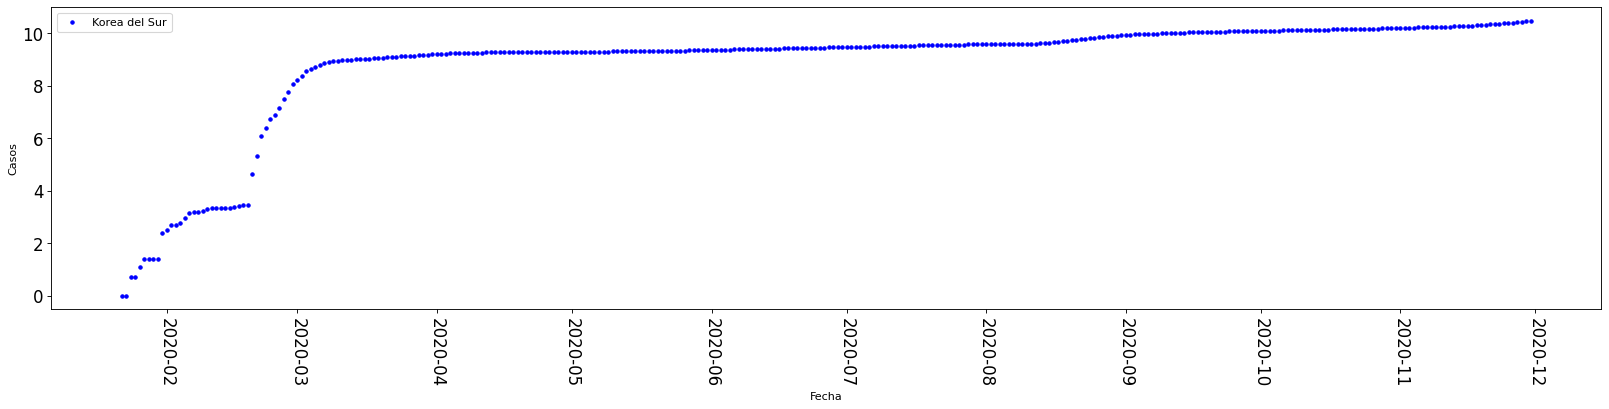

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

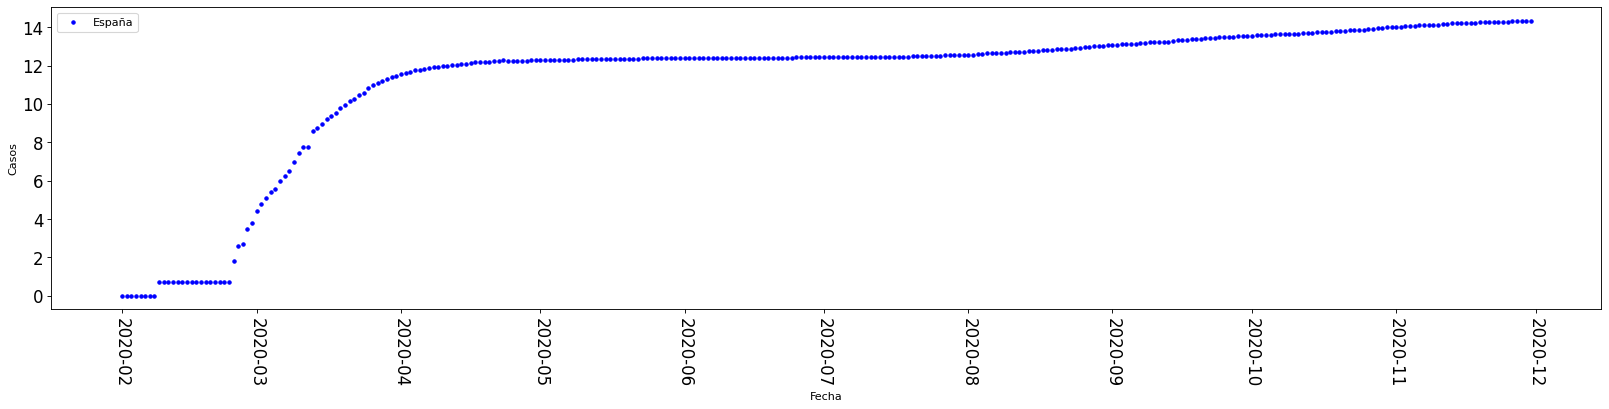

(array([737485., 737516., 737546., 737577., 737607., 737638., 737669.,
        737699., 737730., 737760.]),
 <a list of 10 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

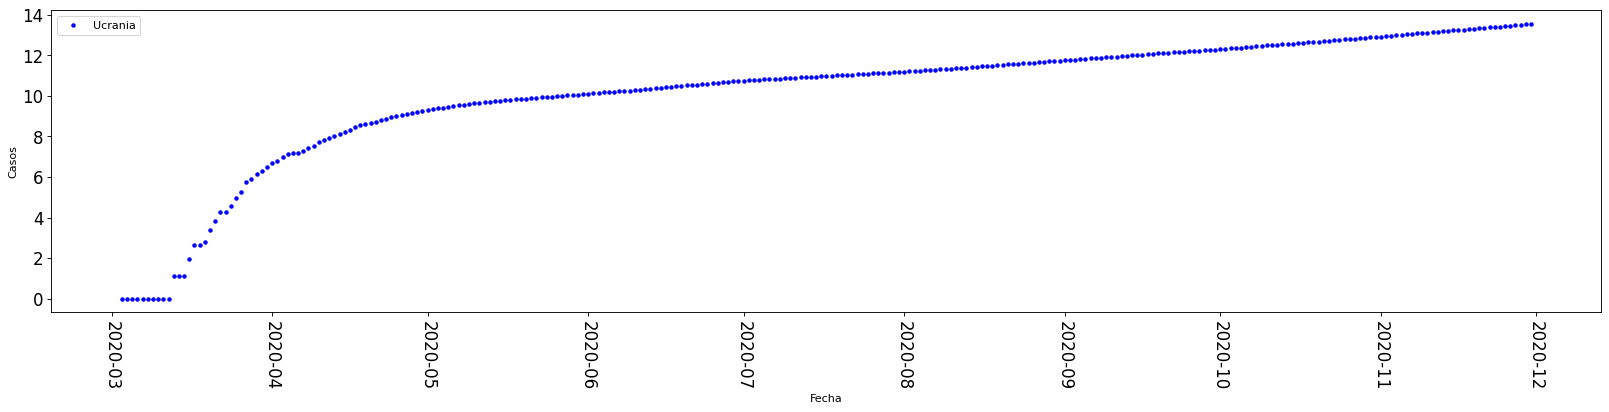

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

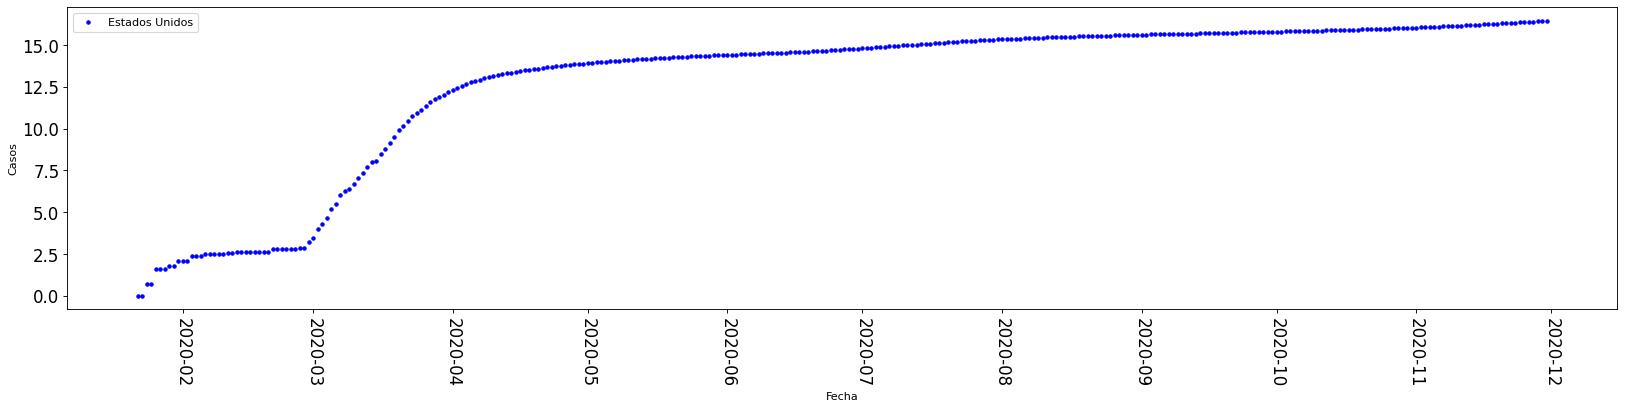

In [969]:
# Grafico logaritmicamente para comprender los diferentes momentos y como busco la primer ola, pongo fecha los primeros meses

paises = ['Argentina', 'Canada', 'Francia', 'India', 'Japon', 'Rusia',
       'Korea del Sur', 'España', 'Ucrania', 'Estados Unidos']

fechalim = '2020-12-01'

for i in paises:
  fig,ax = plt.subplots(figsize=(25,5), dpi= 80)
  mascara = (datos.loc[:,'pais'] == i ) & (datos.loc[:,'fecha'] < fechalim)
  datos_aux = datos[mascara]
  # dias = np.arange(datos_aux.shape[0]) por si lo quiero ver en días, cambio la variable en la siguiente línea de código por "dias"
  plt.plot(datos_aux.fecha, np.log(datos_aux.casos_totales), 'b.', label = i)    
  plt.xticks(rotation=-90)
  plt.xlabel('Fecha')
  plt.ylabel('Casos')
  plt.legend()
  plt.show()

Como no se podía observar bien todos juntos, lo pase a individual

### Tomo los datos de fecha a mano para cada país:

- Argentina = 03-20 al 04-20
- Canada = 03-20 al 04-21
- Francia = 03-20 al 05-20
- India = 03-20 al 04-20
- Japon = 02-20 al 03-20
- Rusia = 03-20 al 04-20
- Korea del Sur = 02-20 al 03-20
- España = 03-20 al 04-20
- Ucrania = 03-20 al 04-20
- Estados Unidos = 03-20 al 04-20

In [970]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [971]:
datos.sort_values('fecha', inplace = True)

In [972]:
FechaInicio = ['2020-03','2020-03','2020-03','2020-03','2020-02','2020-03','2020-02','2020-03','2020-03','2020-03']
FechaFinal = ['2020-04','2020-04','2020-05','2020-04','2020-03','2020-04','2020-03','2020-04','2020-04','2020-04']

k = []
t0 = []
x=[]
y=[]

for i in range(len(paises)):
  mascara=(datos.loc[:,'pais'] == paises[i] ) & (datos.loc[:,'fecha'] >= FechaInicio[i]) & (datos.loc[:,'fecha'] <= FechaFinal[i])
  data_aux = datos[mascara]
  y_graf=data_aux.casos_totales.to_numpy()
  x_graf=np.arange(0,len(y_graf))
  y.append(y_graf)
  x.append(x_graf)
  popt, pcov = curve_fit(exponencial,x_graf,y_graf)
  k.append(popt[0])
  t0.append(popt[1])

df["K"] = k
df["t0"] = t0

In [973]:
k

[0.15715486324047015,
 0.1656953382446132,
 0.04896374589616845,
 0.15989282195092264,
 0.10527963564218193,
 0.20501563168374032,
 0.27560850252541935,
 0.13523811313716402,
 0.22998826530251698,
 0.18142440362331075]

In [974]:
t0

[-15.90909743793109,
 -25.20610772255468,
 -189.59020640002026,
 -15.971146094842648,
 -24.576107317828153,
 -7.737944833704283,
 -1.014326341688891,
 -55.093946360546575,
 -0.22041147386692617,
 -37.171257662701144]

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

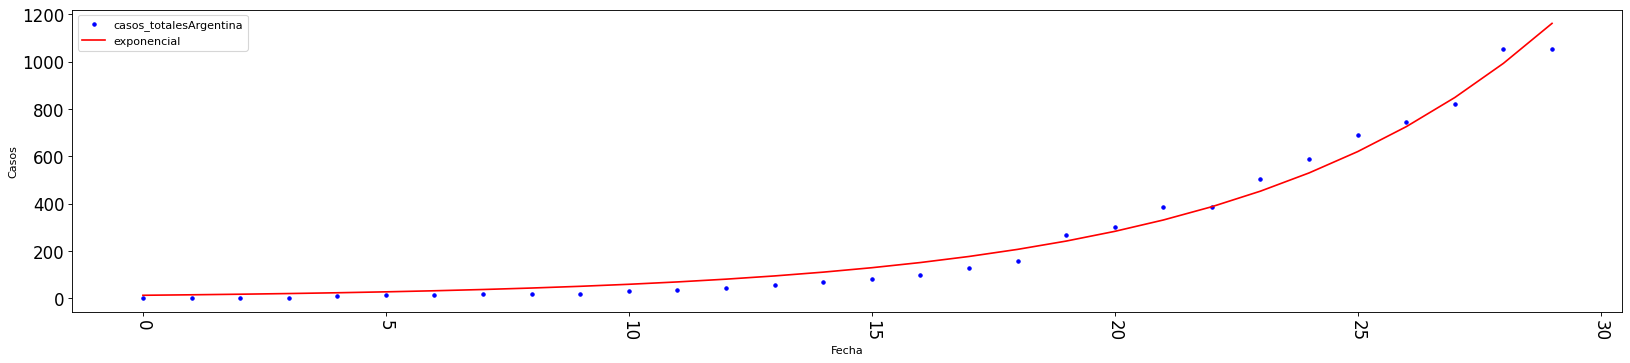

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

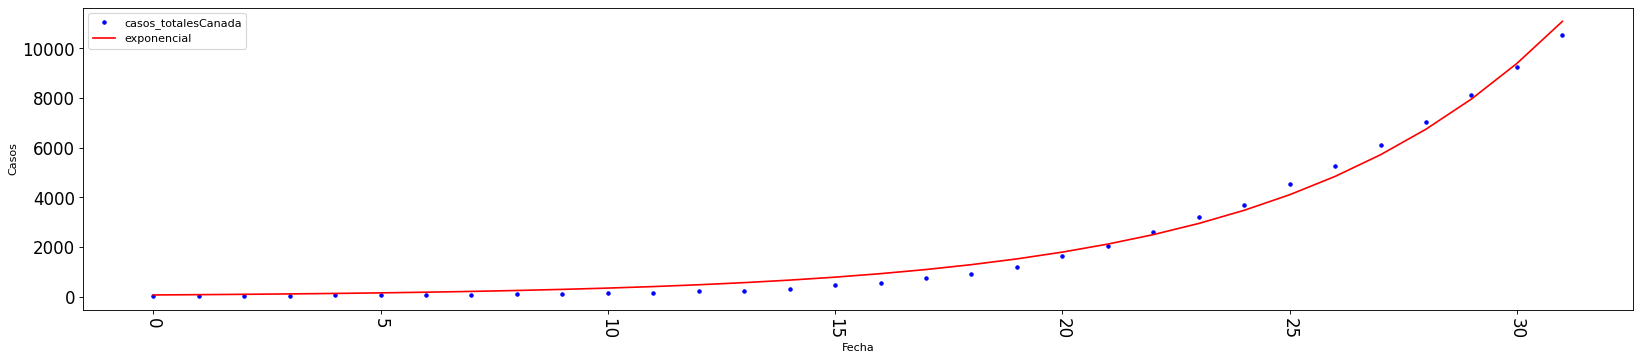

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

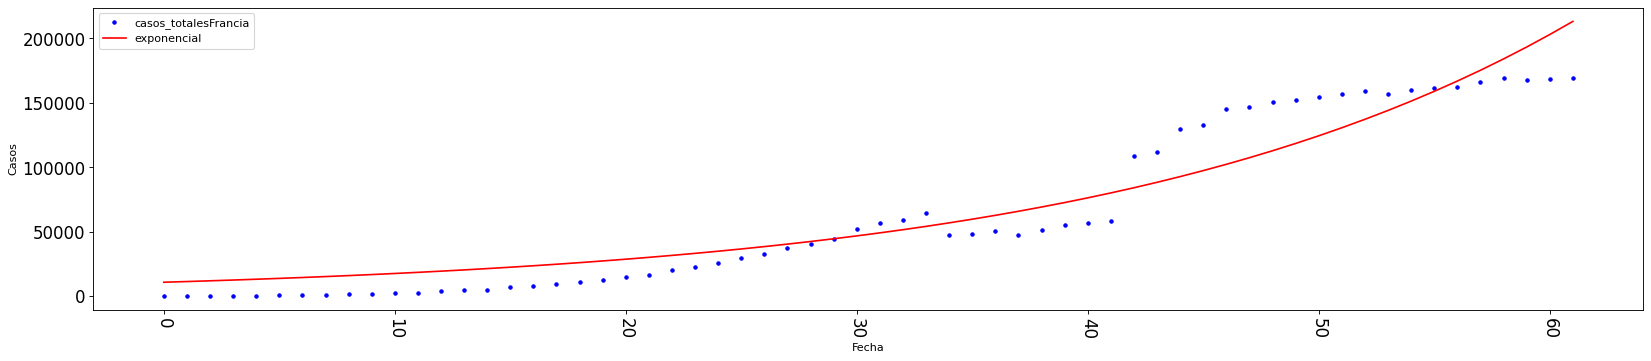

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

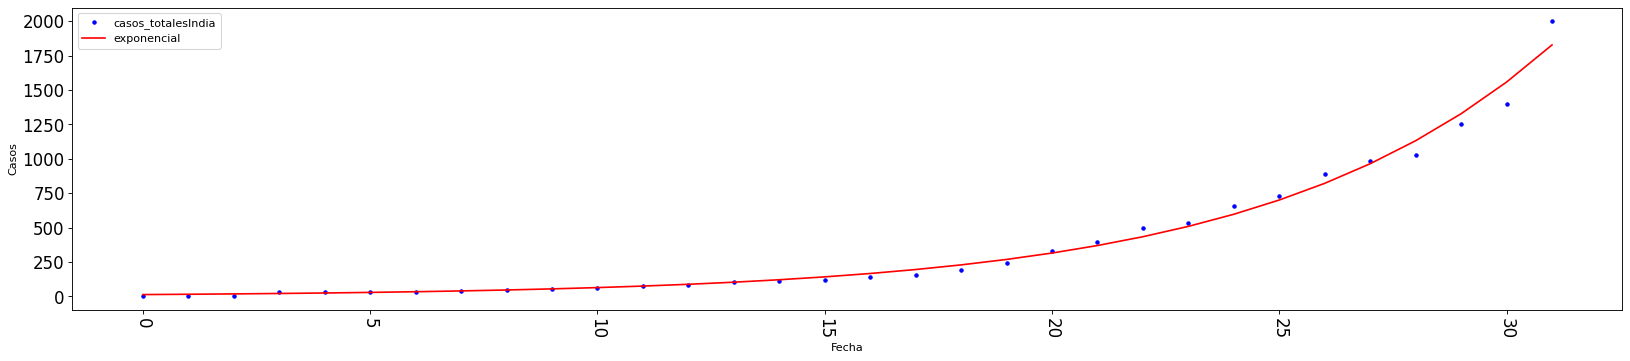

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

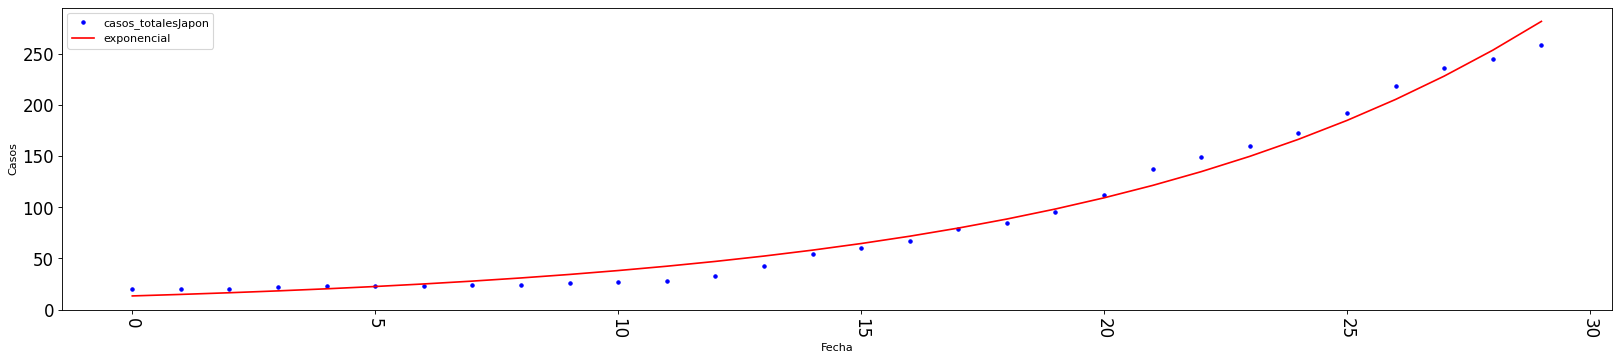

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

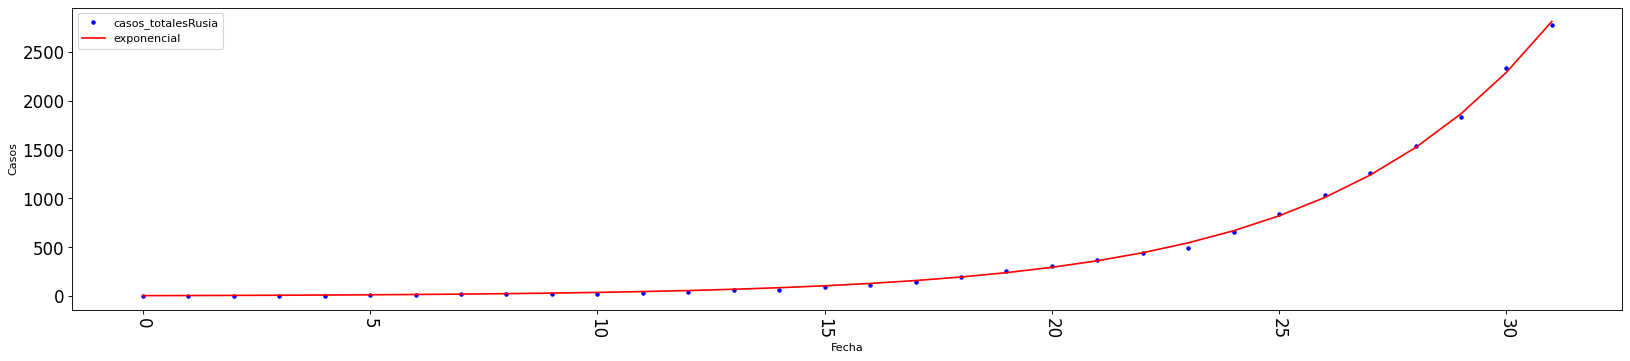

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

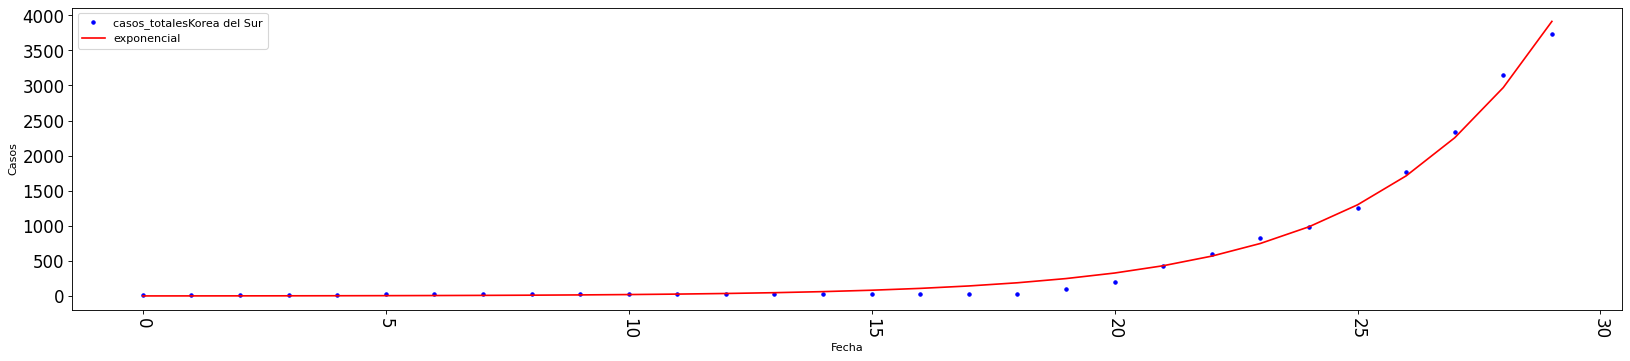

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

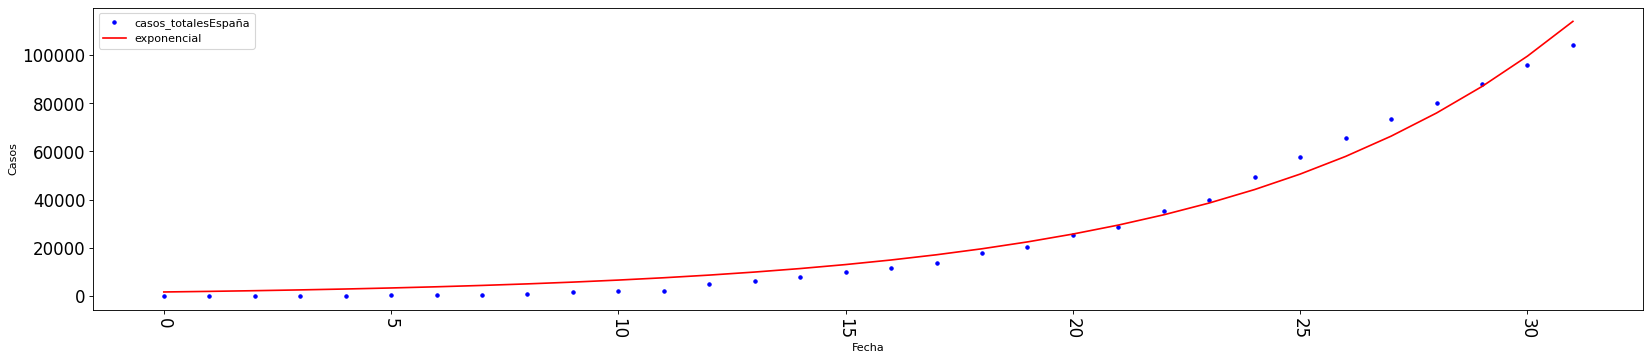

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

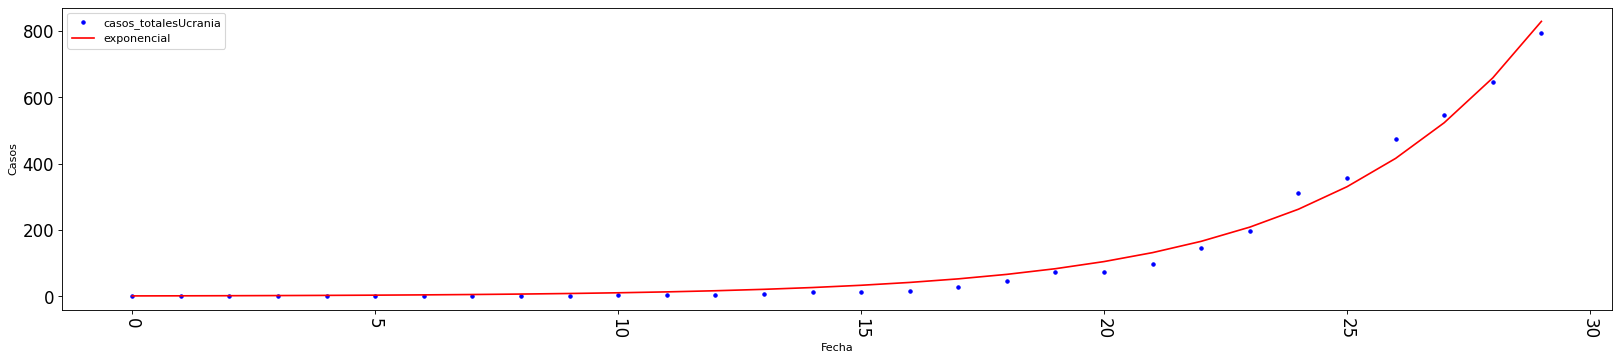

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

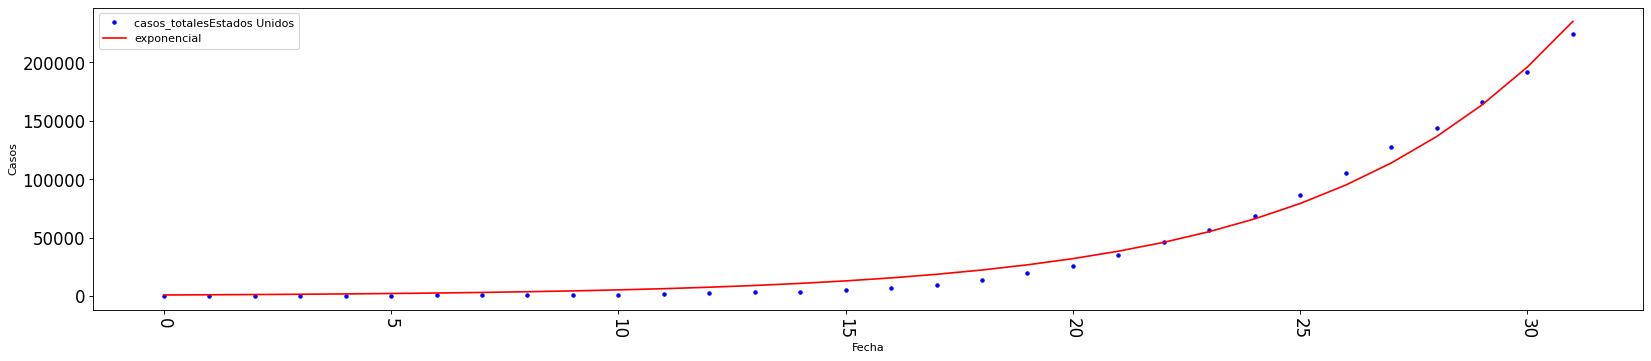

In [975]:
# Grafico los resultados 

for i in range(len(paises)):  
  fig,ax = plt.subplots(figsize=(25,5), dpi= 80)
  plt.plot(x[i], y[i], 'b.', label = 'casos_totales'+ paises[i]) 
  plt.plot(x[i], exponencial(x[i],k[i],t0[i]), 'r-', label = 'exponencial')
  plt.xticks(rotation=-90)
  plt.xlabel('Fecha')
  plt.ylabel('Casos')
  plt.legend()
  plt.show()

In [976]:
# Chequeo los estadísticos de k_paises
print(np.mean(k), np.std(k))

0.1664261321246508 0.06026043957008404


# 2. Bootstrap:

Para reesamplear la cantidad de k

In [977]:
def remuestreo(datos):
  remuestra=np.zeros(len(datos))
  i=0
  while i<len(datos):
    remuestra[i]=datos[np.random.randint(len(datos))]
    i=i+1
  return remuestra  

(array([2., 0., 4., 0., 2., 0., 1., 0., 0., 1.]),
 array([0.10527964, 0.1177505 , 0.13022136, 0.14269222, 0.15516309,
        0.16763395, 0.18010481, 0.19257568, 0.20504654, 0.2175174 ,
        0.22998827]),
 <a list of 10 Patch objects>)

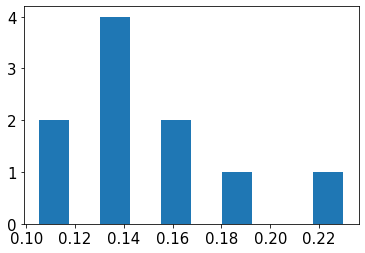

In [978]:
datos_rem= remuestreo(ks)
plt.hist(datos_rem)

In [979]:
# Desplego el bootstrap 
np.random.seed(8) # Elegir semilla.
nrep = 10000
datos_k = ks # Tenemos las k de los 10 países
medias = []

for i in np.arange(nrep):
  datos_rem=remuestreo(datos_k)
  medias.append(np.mean(datos_rem))


mu_muestra    = np.mean(medias)
sigma_muestra = np.std(medias)
print(mu_muestra, sigma_muestra)

0.16673016396593904 0.019006465581009716


<Figure size 1280x960 with 0 Axes>

(array([1.000e+00, 3.000e+00, 2.200e+01, 1.120e+02, 2.680e+02, 6.550e+02,
        1.263e+03, 1.798e+03, 1.985e+03, 1.817e+03, 1.126e+03, 6.040e+02,
        2.540e+02, 6.900e+01, 2.300e+01]),
 array([0.08486953, 0.09457667, 0.10428381, 0.11399095, 0.12369808,
        0.13340522, 0.14311236, 0.1528195 , 0.16252664, 0.17223378,
        0.18194092, 0.19164805, 0.20135519, 0.21106233, 0.22076947,
        0.23047661]),
 <a list of 1 Patch objects>)

Text(0.5, 1.0, 'Distribución resultante de Bootstrap de $k_{cont/millon}$')

Text(0, 0.5, 'Frequency')

Text(0.5, 0, '$k_{cont/millon}$')

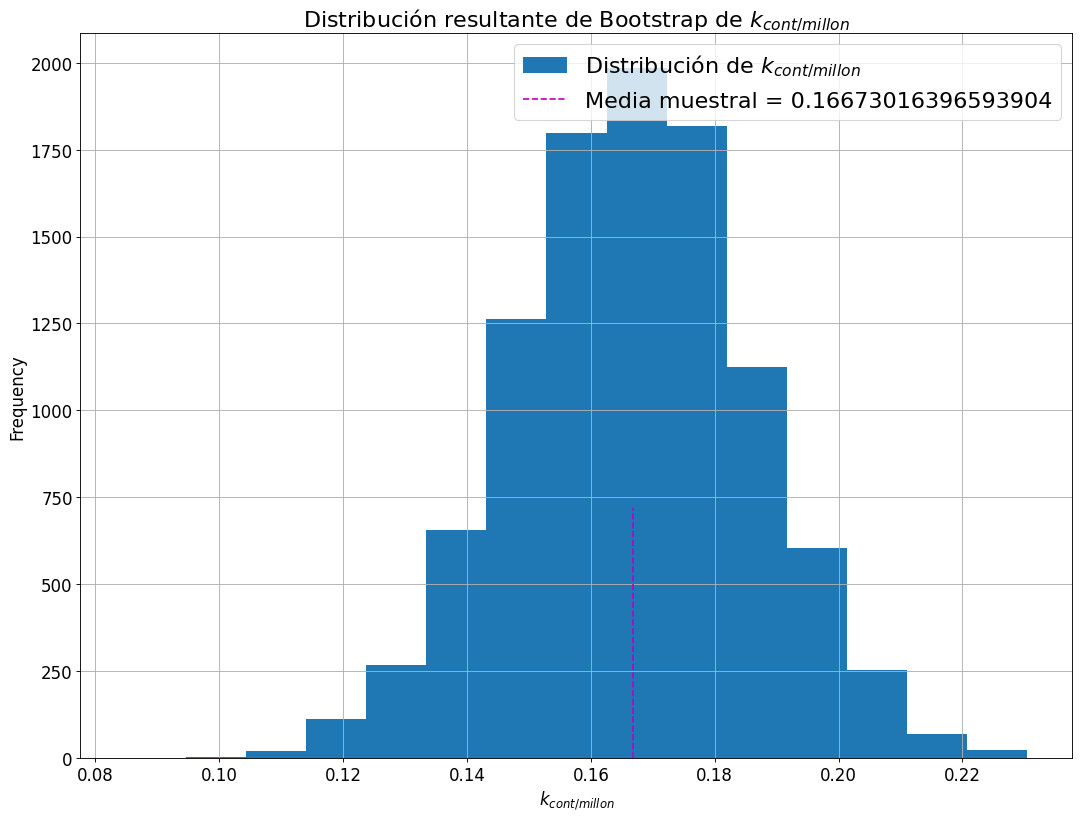

In [980]:
#grafico

plt.figure(figsize=(8*scale, 6*scale), dpi=80)
plt.hist(medias,bins=15, histtype = 'stepfilled',label = 'Distribución de $k_{cont/millon}$')
plt.vlines(mu_muestra, 0,9*80, colors='m', linestyles='dashed', label='Media muestral = '+ str(np.mean(medias)))
plt.title('Distribución resultante de Bootstrap de $k_{cont/millon}$', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('$k_{cont/millon}$', fontsize = 15)
plt.legend(fontsize = 20)
plt.grid()
plt.show()

In [981]:
#Traigo los datos nuevamente para buscar las K del mundo

datos_mundo=pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 4/cumulative-deaths-and-cases-covid-19.csv')

datos_mundo.rename(columns = {'Entity':'pais'}, inplace = True) 
datos_mundo.rename(columns = {'Day':'fecha'}, inplace = True) 
datos_mundo.rename(columns = {'Total confirmed cases of COVID-19'	:'casos_totales'}, inplace = True)  
datos_mundo.drop(columns=['Total confirmed deaths due to COVID-19'], inplace = True)

mascara=(datos_mundo.loc[:,'pais'] == 'World')
datos_mundo = datos_mundo[mascara]

# Paso a formato de fecha la columna fecha
datos_mundo['fecha'] = pd.to_datetime(datos_mundo.fecha)

datos_mundo

,pais,Code,fecha,casos_totales
147636,World,OWID_WRL,2020-01-22,557.0000
147637,World,OWID_WRL,2020-01-23,655.0000
147638,World,OWID_WRL,2020-01-24,941.0000
147639,World,OWID_WRL,2020-01-25,1434.0000
147640,World,OWID_WRL,2020-01-26,2118.0000
...,...,...,...,...
148344,World,OWID_WRL,2021-12-30,286503512.0000
148345,World,OWID_WRL,2021-12-31,288194306.0000
148346,World,OWID_WRL,2022-01-01,289309748.0000
148347,World,OWID_WRL,2022-01-02,290187418.0000


(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

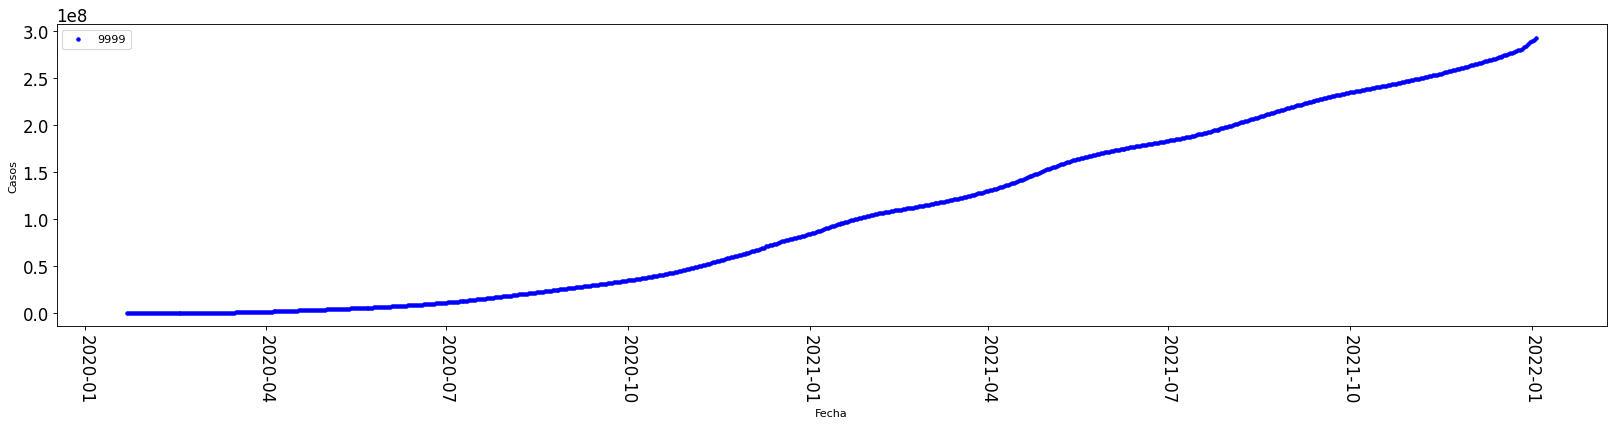

In [982]:
# Grafico
fig,ax = plt.subplots(figsize=(25,5), dpi= 80)
plt.plot(datos_mundo.fecha, datos_mundo.casos_totales, 'b.', label = i)    
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()
plt.show()


(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699., 737730., 737760.]),
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

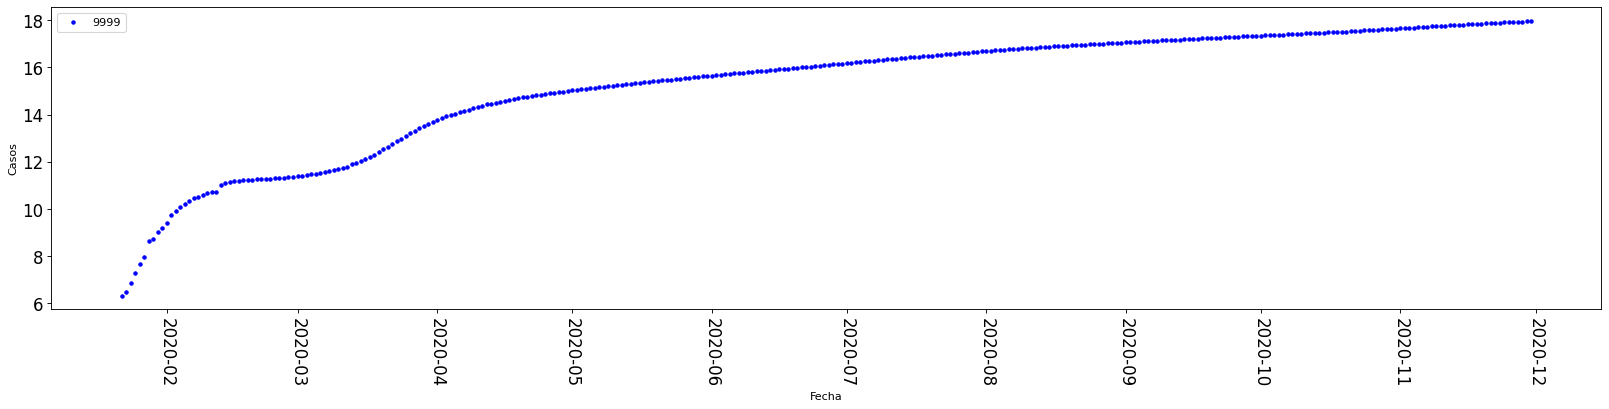

In [983]:
# Grafico logaritmico y con límite para ver bien la primer ola

fecha_limite = '2020-12-01'

fig,ax = plt.subplots(figsize=(25,5), dpi= 80)
mascara = (datos_mundo.loc[:,'fecha'] < fecha_limite)
plt.plot(datos_mundo[mascara].fecha, np.log(datos_mundo[mascara].casos_totales), 'b.', label = i)    
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()
plt.show()

In [984]:
# Por observacion establezco las fechas de inicio y de fin
FechaInicioMundo = '2020-03'
FechaFinalMundo='2020-04'

mascara=(datos_mundo.loc[:,'fecha'] >= FechaInicioMundo) & (datos_mundo.loc[:,'fecha'] <= FechaFinalMundo)
data_aux = datos_mundo[mascara]

y_mundo=data_aux.casos_totales.to_numpy()
x_mundo=np.arange(0,len(y_mundo))

popt, pcov = curve_fit(exponencial,x_mundo,y_mundo)

k_mundo = popt[0]
t0_mundo = popt[1]
print('k mundial→ ', k_mundo)
print('t0 mundial→ ',t0_mundo)

k mundial→  0.09821475888654929
t0 mundial→  -109.31658459017522


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

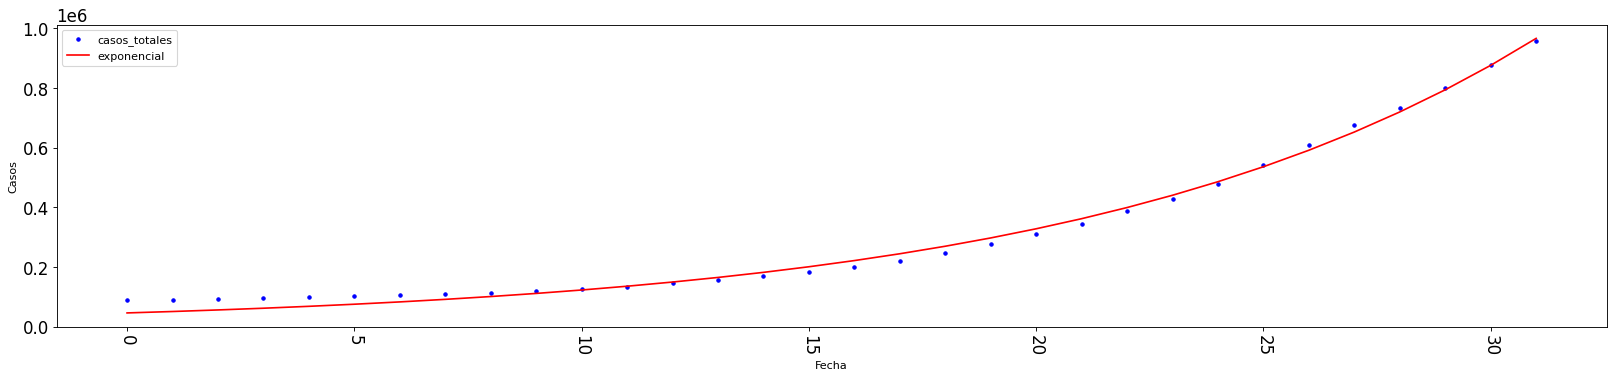

In [985]:
# Grafico los resultados 

fig,ax = plt.subplots(figsize=(25,5), dpi= 80)
plt.plot(x_mundo, y_mundo, 'b.', label = 'casos_totales') 
plt.plot(x_mundo, exponencial(x_mundo,k_mundo,t0_mundo), 'r-', label = 'exponencial')
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()
plt.show()

In [986]:
print('k países:', mu_muestra)
print('k mundial:', k_mundo)

k países: 0.16673016396593904
k mundial: 0.09821475888654929


###Procedimiento

De cada país se observó la gráfica logarítmica, decidí la fecha según observación y hallamos los k y t0 de cada país a partir del método de los cuadrados mínimos. 

Armé dataset de los 10 K e hice un bootstraping, asumí la distribución normal y calculé el valor de k a partir del valor de los 10 países. Luego se comparó con el k mundial.

A partir de dicha comparación, se observa una diferencia grande entre ambos, más de un 65%.
Esto probablemente se deba a la diferencia entre países que hicieron cuarentena con países que no y también puede deberse a que muchos países no contaban con la capacidad (económica, física, etc) de realizar los testeos al mismo tiempo.

# 3. Armado de clasificador

La idea es armar un clasificador que me separe paises que hicieron y que no hicieron cuarentena.

In [987]:
# Vuelvo a Cargar un dataset que me muestre los nuevos casos (no el acumulado) para próximos análisis, ya que necesito observar las olas.

datos3=pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 4/daily-tests-and-daily-new-confirmed-covid-cases.csv')

datos3.rename(columns = {'Entity':'pais'}, inplace = True) 
datos3.rename(columns = {'Day':'fecha'}, inplace = True) 
datos3.rename(columns = {'Daily new confirmed cases due to COVID-19 (rolling 7-day average, right-aligned)'	:'nuevos_casos'}, inplace = True)  
datos3.drop(columns=['Code','new_tests_7day_smoothed','142752-annotations'], inplace = True)

# Paso a formato de fecha la columna fecha
datos3['fecha'] = pd.to_datetime(datos3.fecha)

In [988]:
datos3

,pais,fecha,nuevos_casos
0,Afghanistan,2020-02-26,1.6667
1,Afghanistan,2020-02-27,1.2500
2,Afghanistan,2020-02-28,1.0000
3,Afghanistan,2020-02-29,0.8333
4,Afghanistan,2020-03-01,0.7143
...,...,...,...
153779,Zimbabwe,2020-05-11,0.2857
153780,Zimbabwe,2020-05-12,0.2857
153781,Zimbabwe,2022-01-03,1519.7143
153782,Zimbabwe,2022-01-04,1447.1429


Para armar un clasificador, primero voy a buscar países que hicieron cuarentena y países que no hicieron cuarentena

Países que no hicieron (de ahora en más paises "0"):

- Brazil
- Venezuela
- India
- Bolivia
- Sweden
- Uruguay
- Holanda
- Mexico
- Corea del sur
- Singapur
- Dominican Republic

Países que hicieron (de ahora en más paises "1"):

- Argentina
- Italia
- China
- España
- Nueva Zelanda
- Australia
- Noruega
- Alemania
- Francia
- Peru
- United Kingdom

In [989]:
## Armo lista de países con y si cuarentena:
paises_0 = ['Brazil','Venezuela','India','Bolivia','Sweden','Uruguay','Netherlands','Mexico','South Korea','Singapore','Dominican Republic']
paises_1 = ['Argentina','Italy','China','Spain','New Zealand','Australia','Norway','Germany','France','Peru', 'United Kingdom']
todos_paises = np.concatenate((paises_0,paises_1))
cuarentena = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1]

## Vamos a graficar por separado países que hicieron cuarentena y países que no hicieron cuarentena, para por visual, elegir las fechas de inicio y fin

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

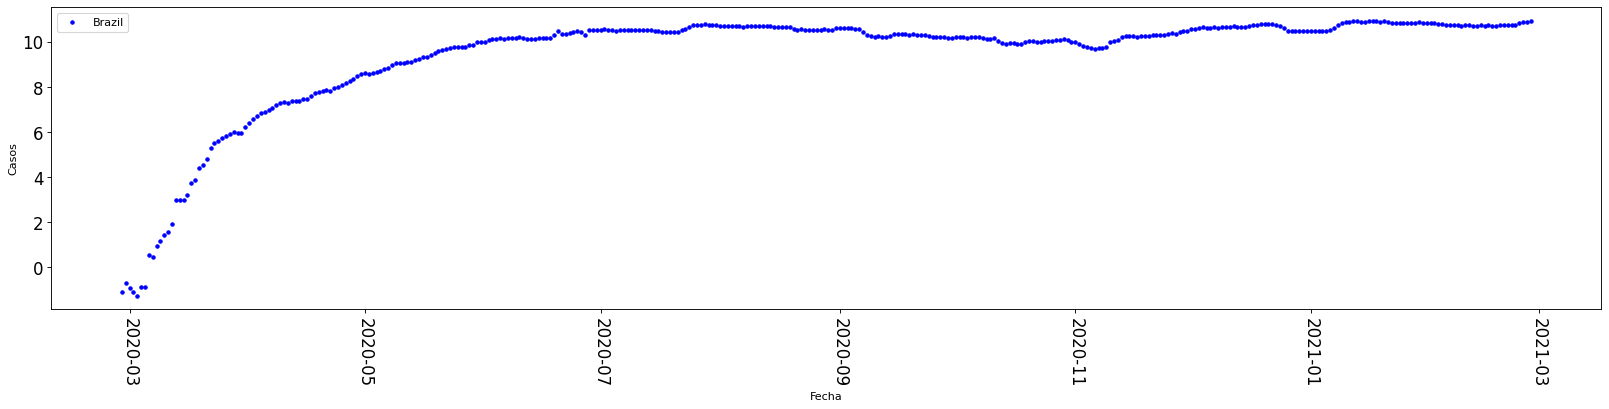

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

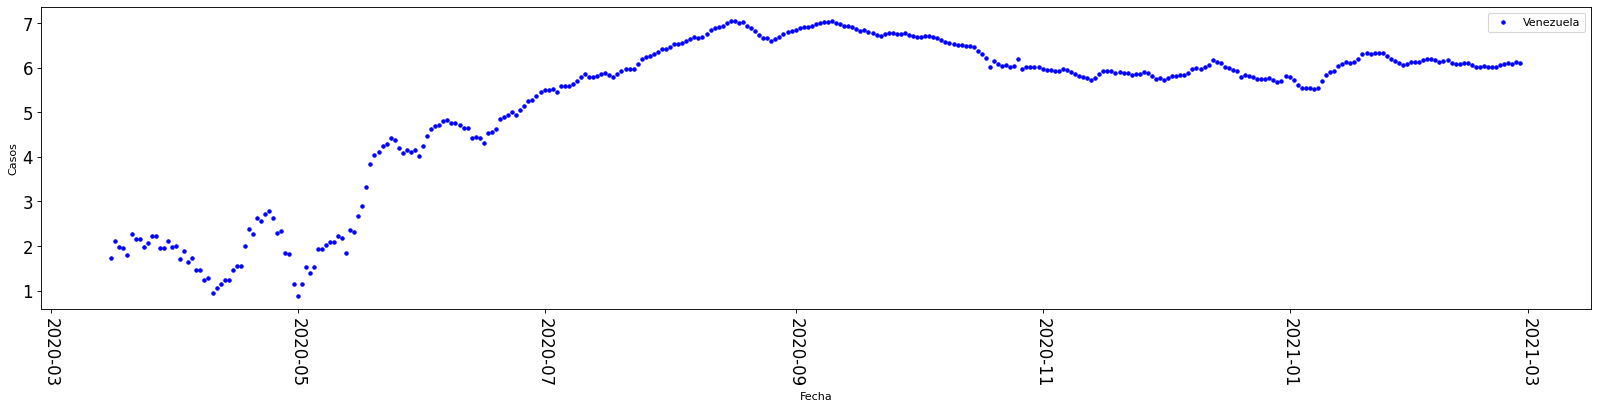

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

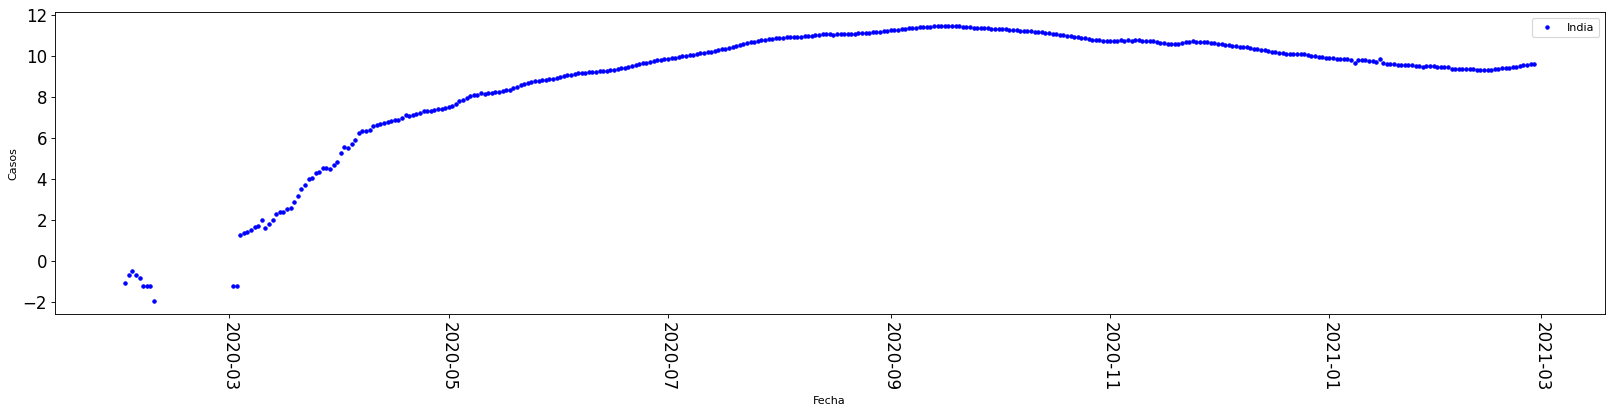

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

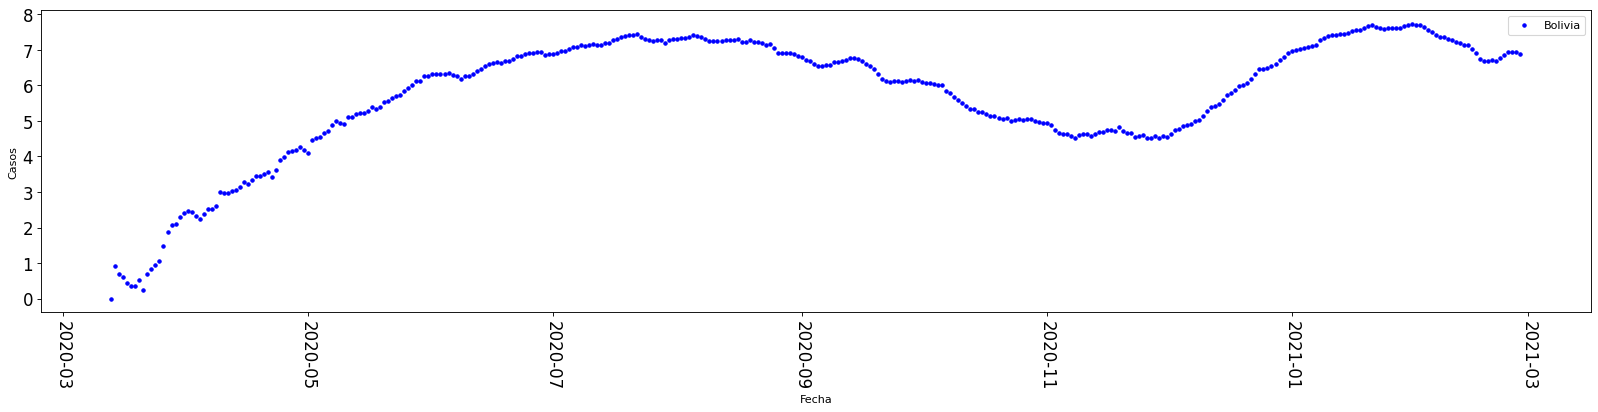

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

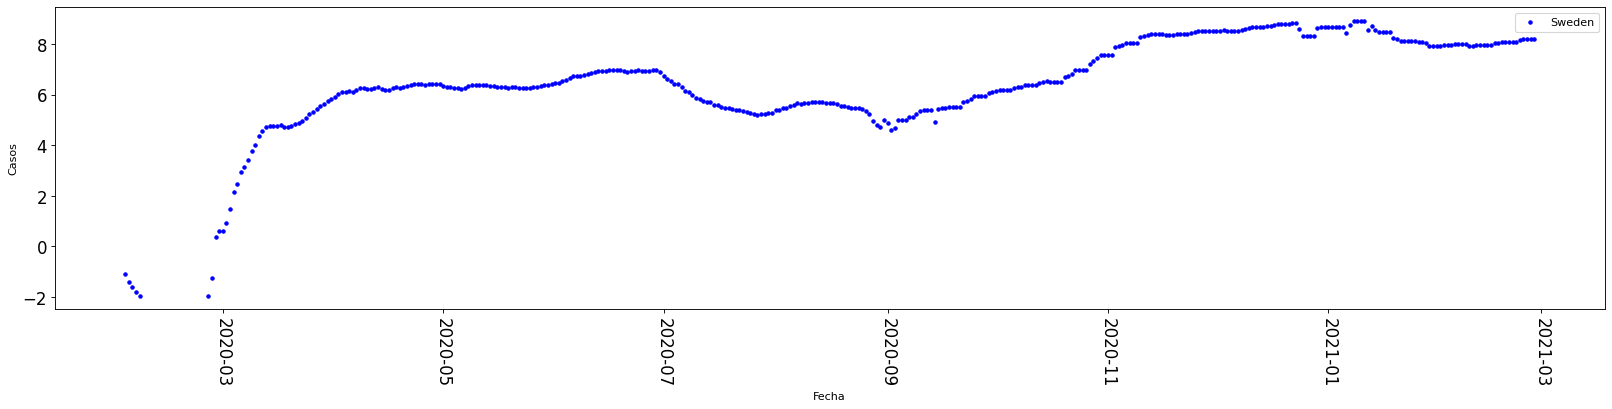

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

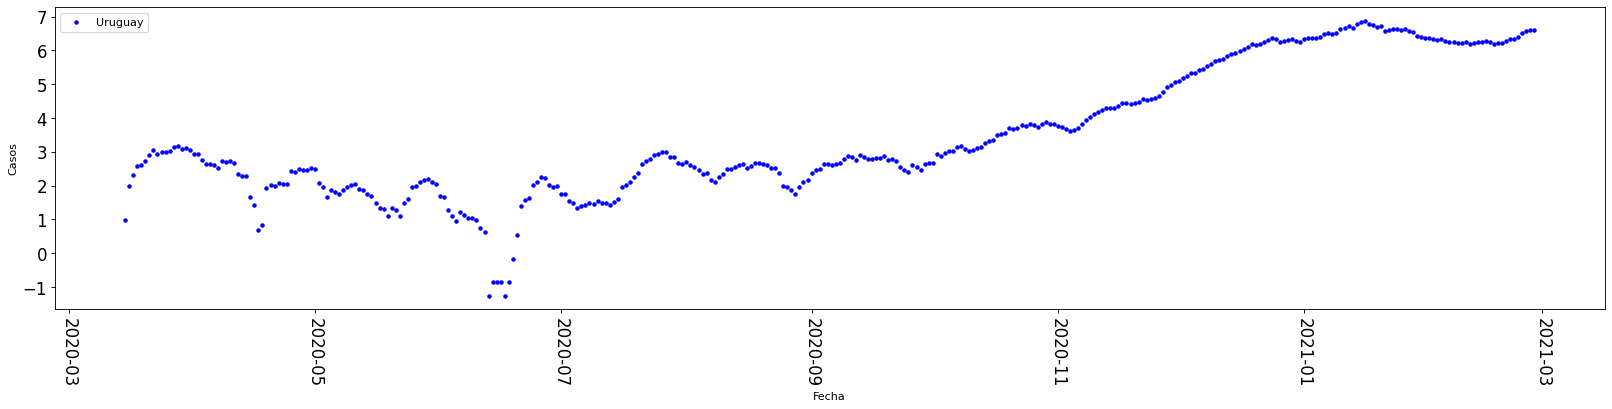

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

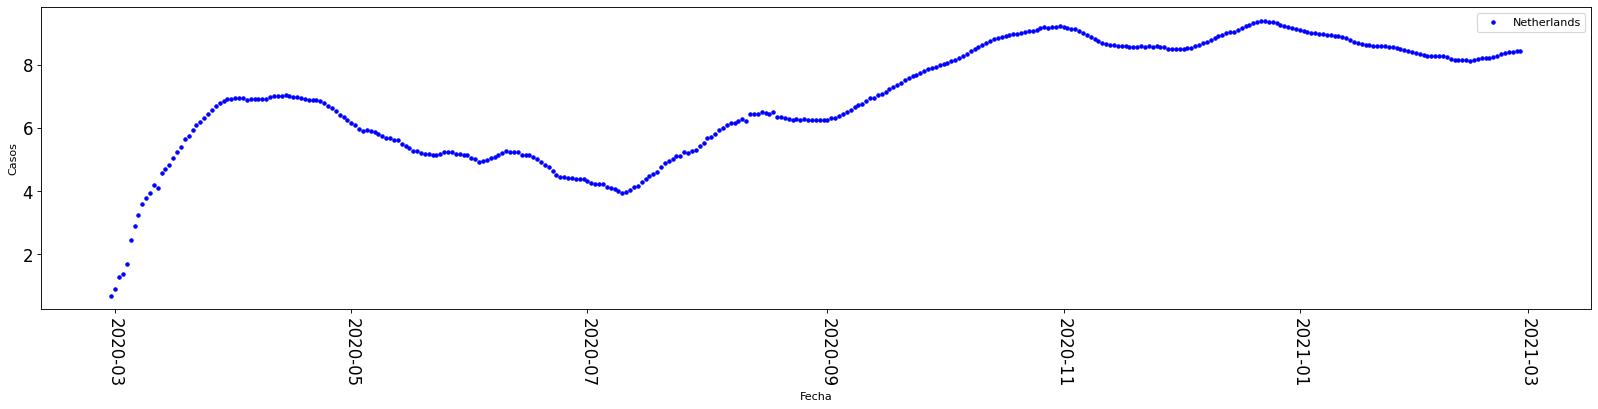

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

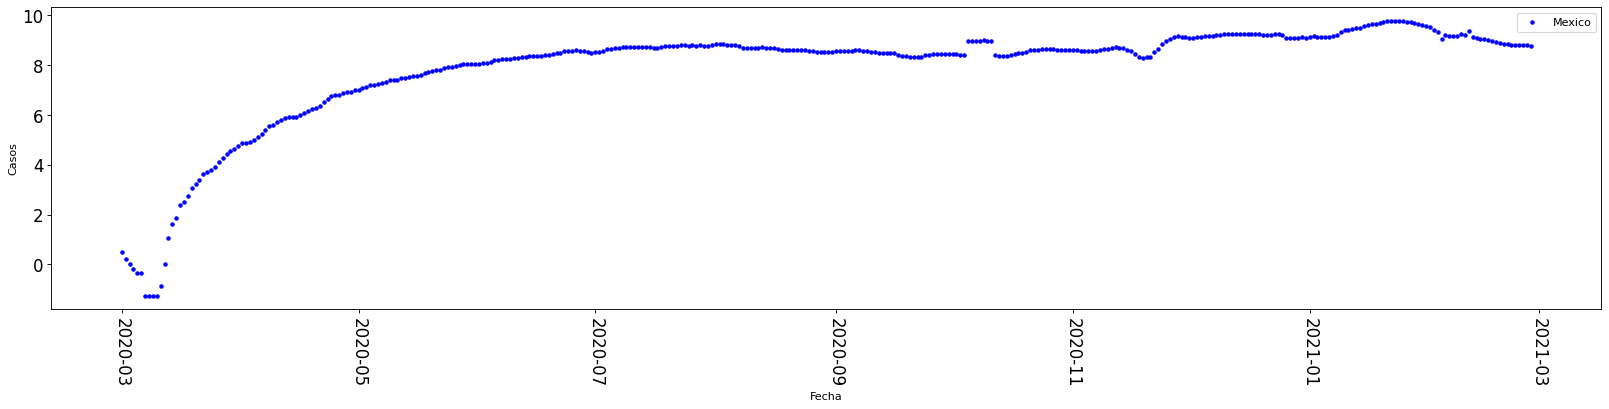

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

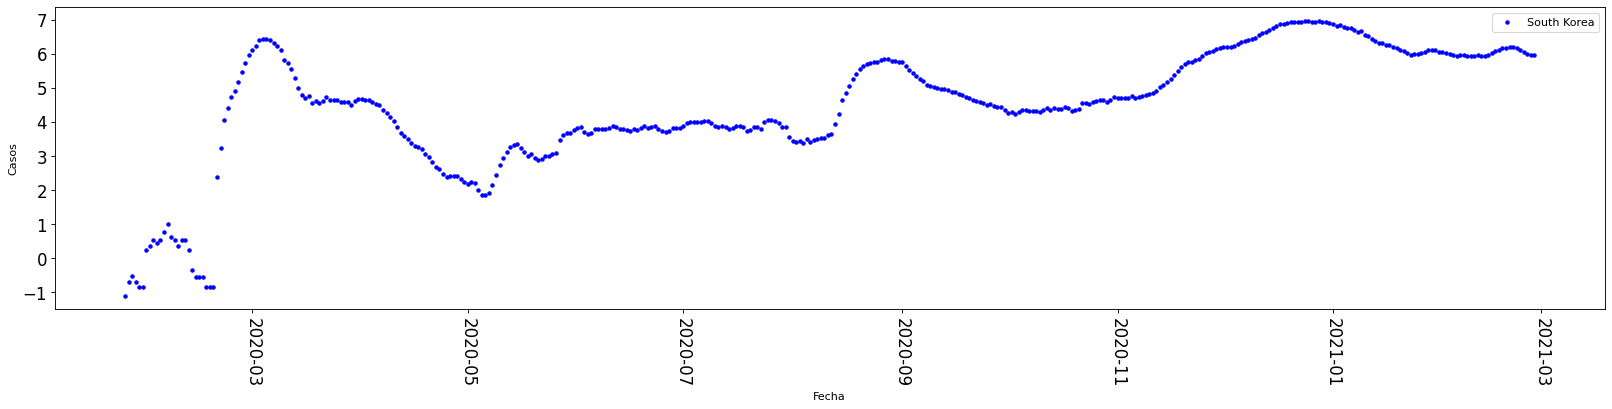

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

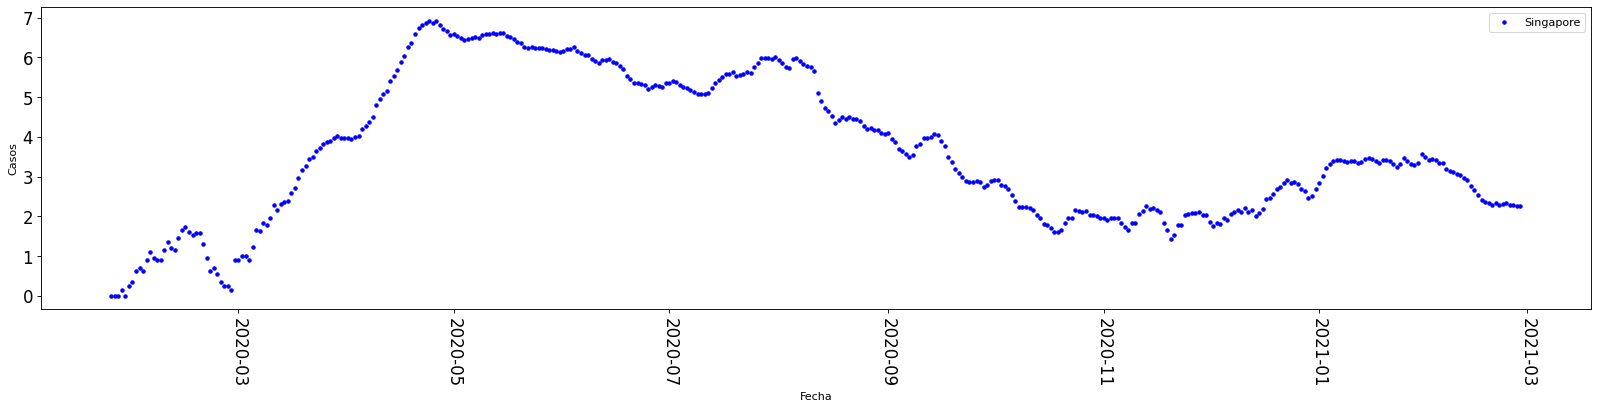

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

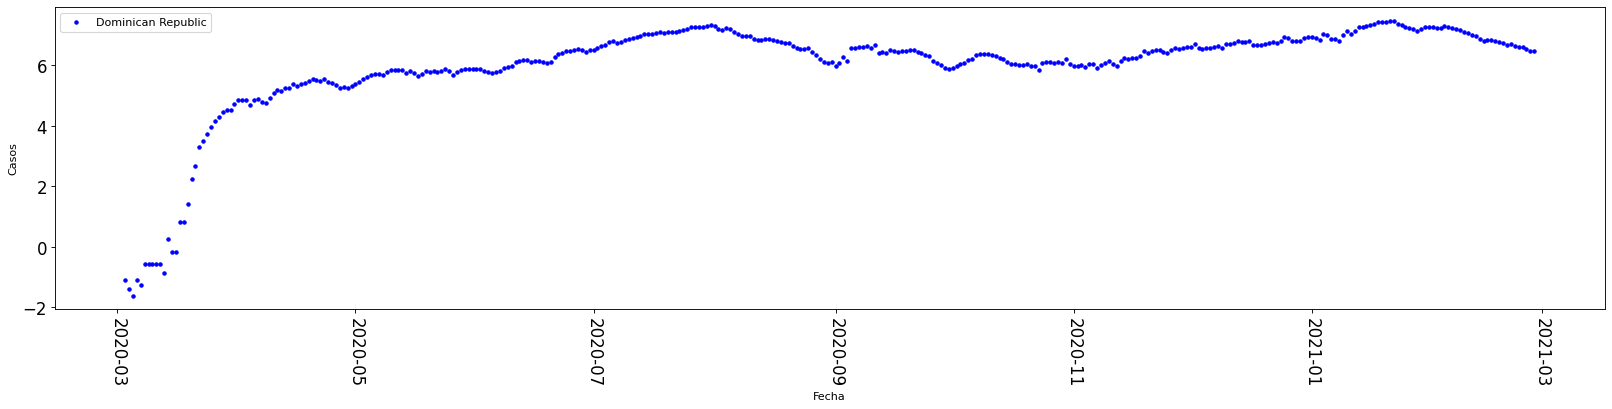

In [990]:
# Grafico por cada pais sin cuarentena logaritmico
fechalim = '2021-02-28'

for i in paises_0:
  fig,ax = plt.subplots(figsize=(25,5), dpi= 80)
  mascara = (datos3.loc[:,'pais'] == i ) & (datos3.loc[:,'fecha'] < fechalim)
  datossincuarentena = datos3[mascara]
  plt.plot(datossincuarentena.fecha, np.log(datossincuarentena.nuevos_casos), 'b.', label = i)    
  plt.xticks(rotation=-90)
  plt.xlabel('Fecha')
  plt.ylabel('Casos')
  plt.legend()
  plt.show()

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

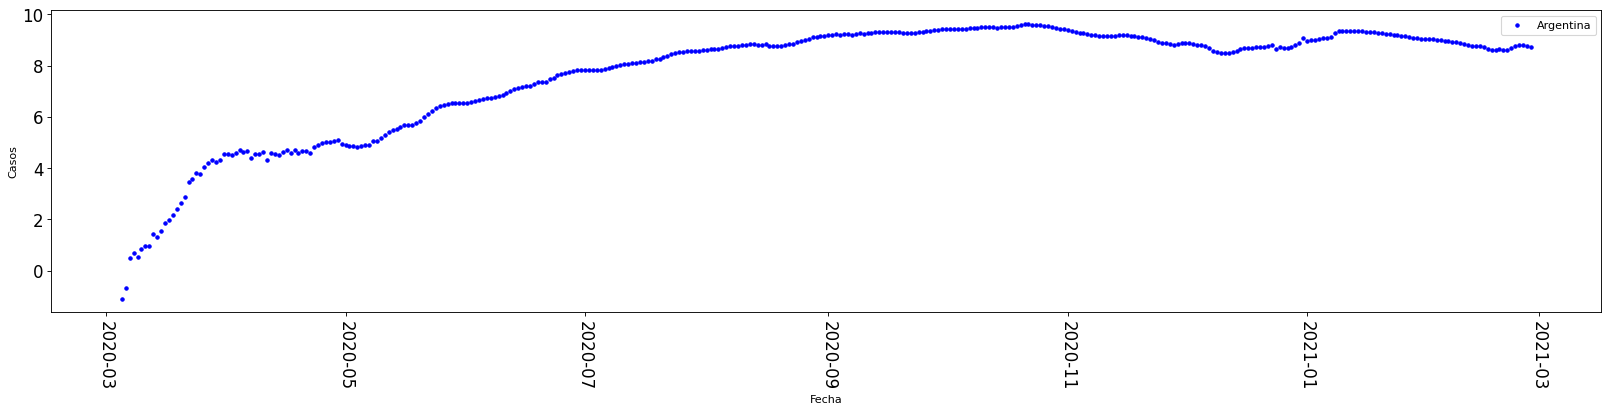

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

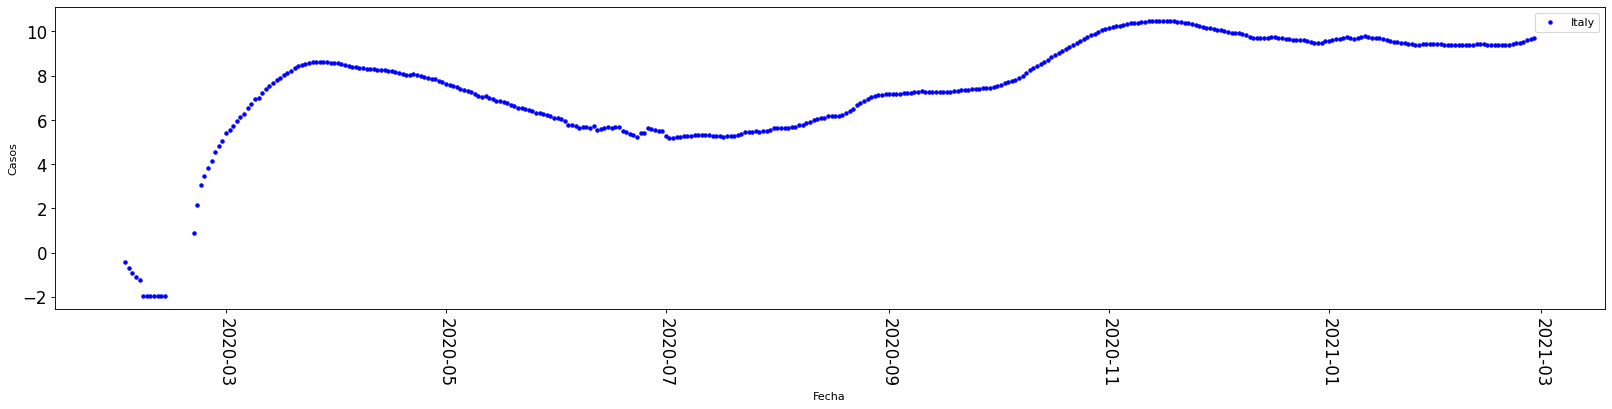

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

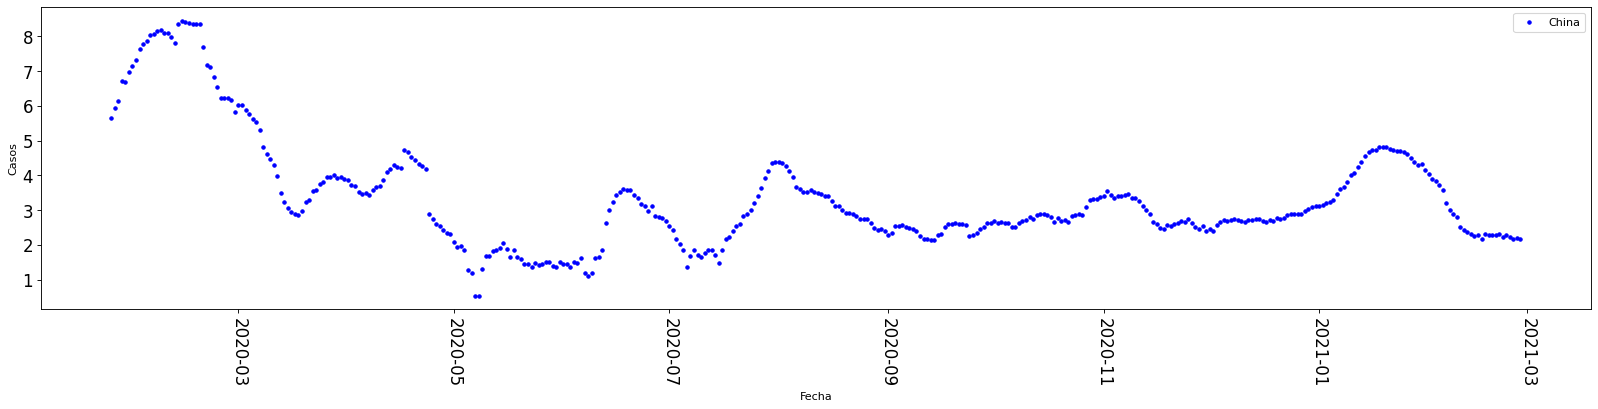

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

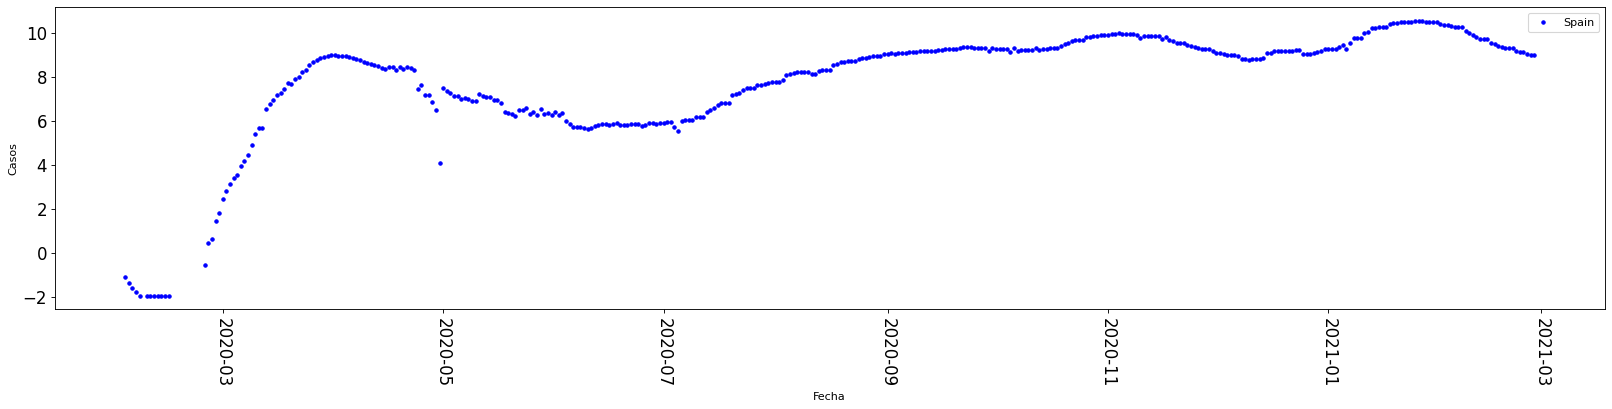

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

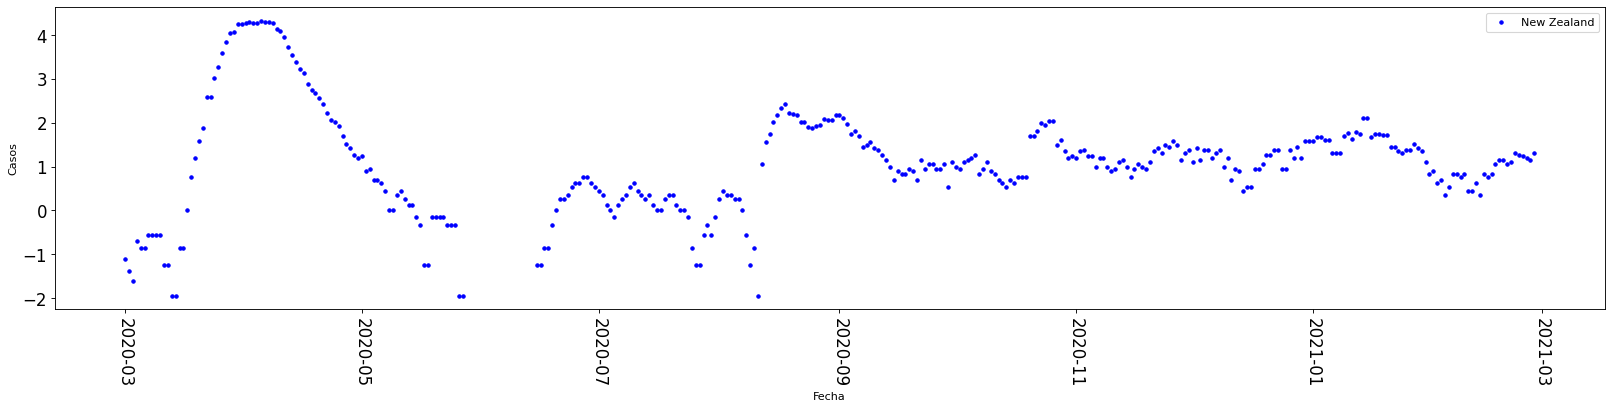

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

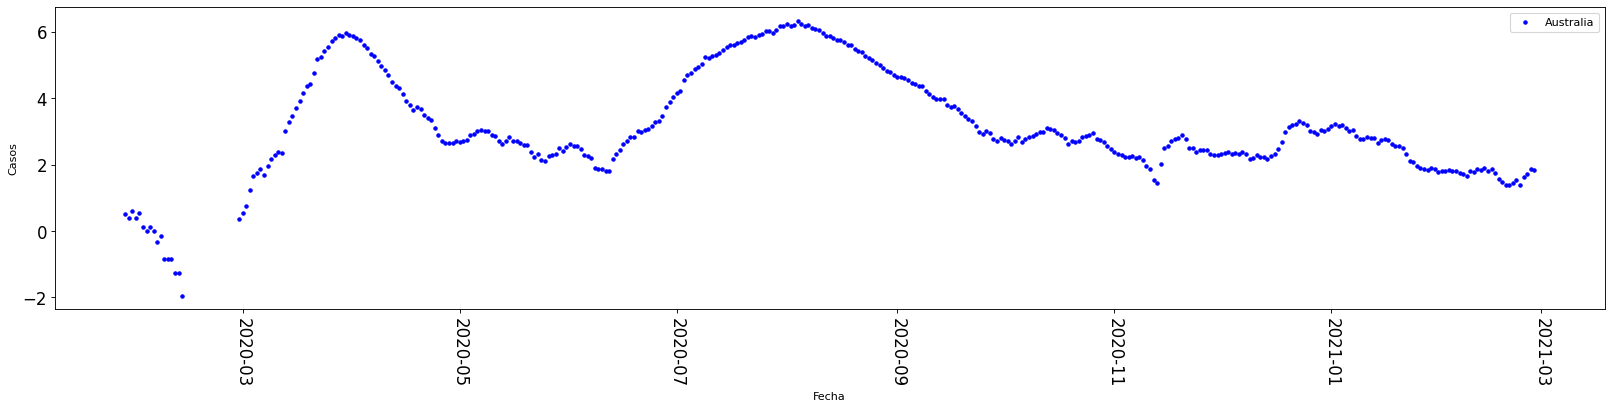

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

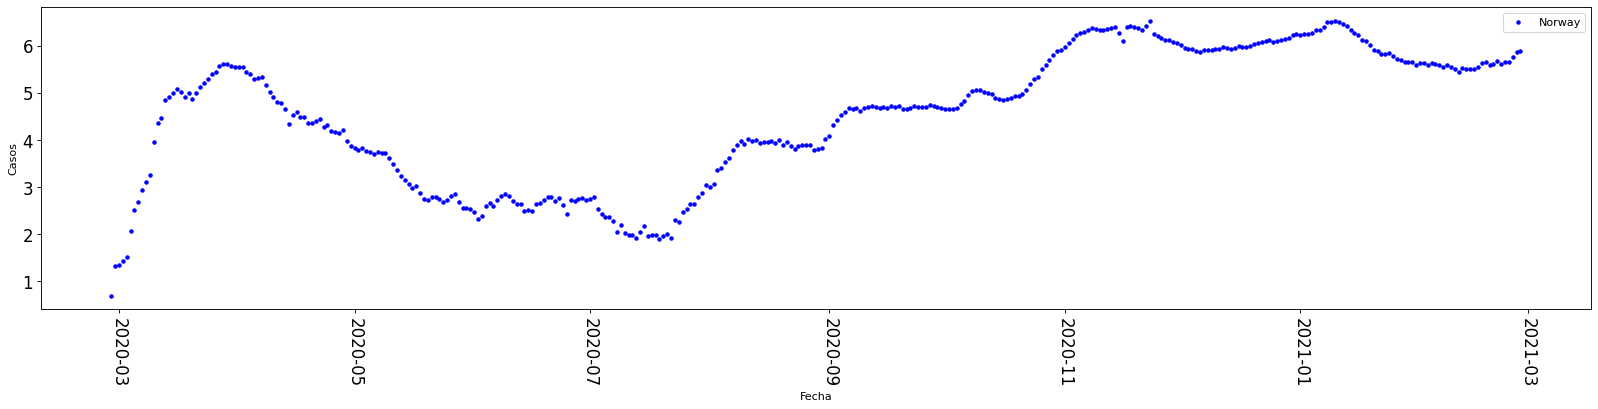

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

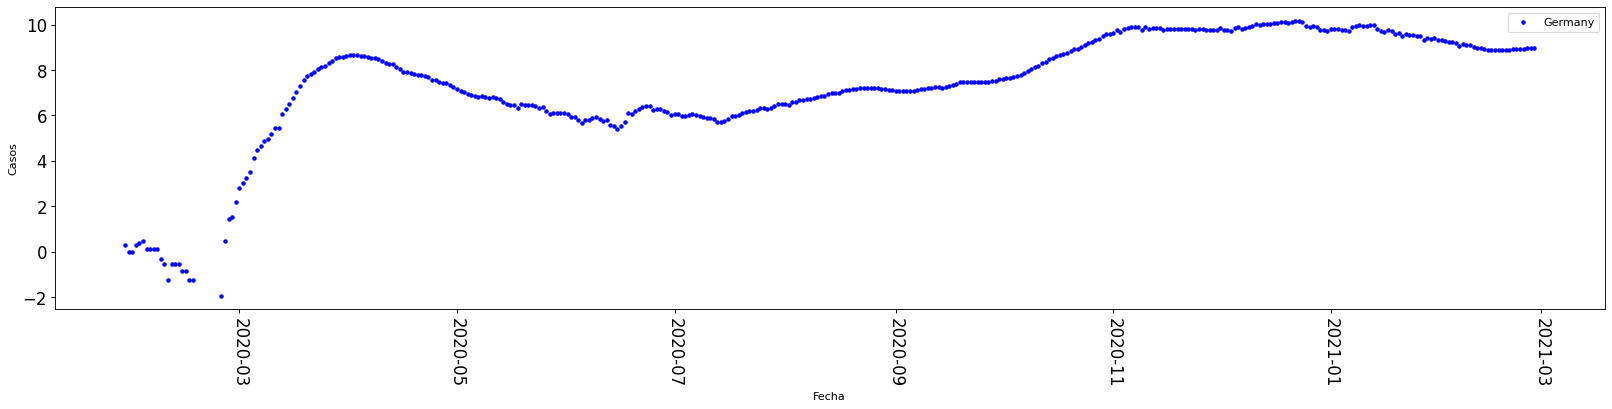

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

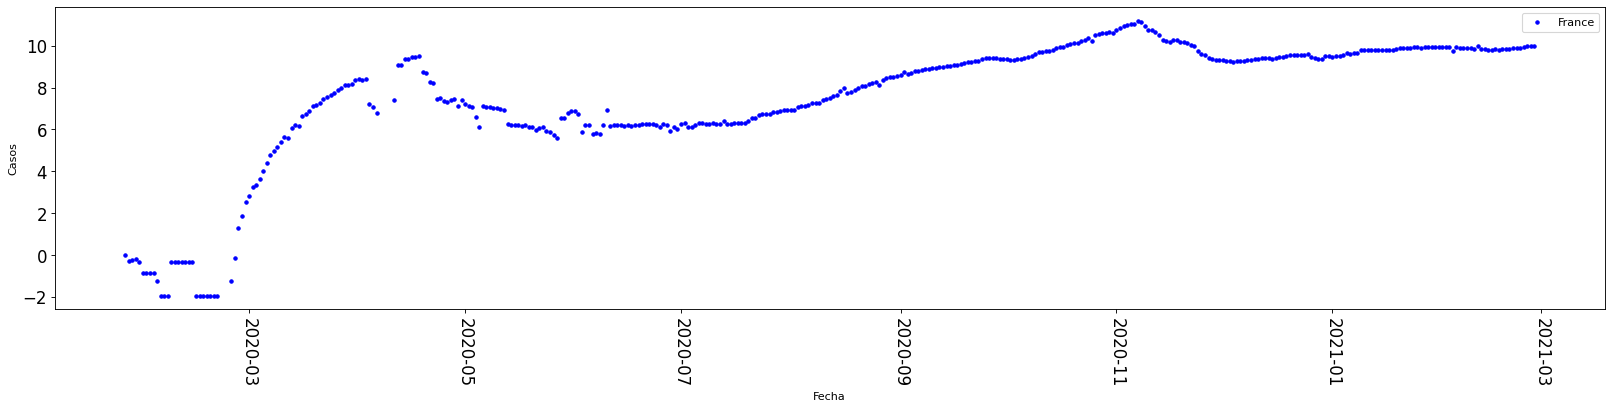

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

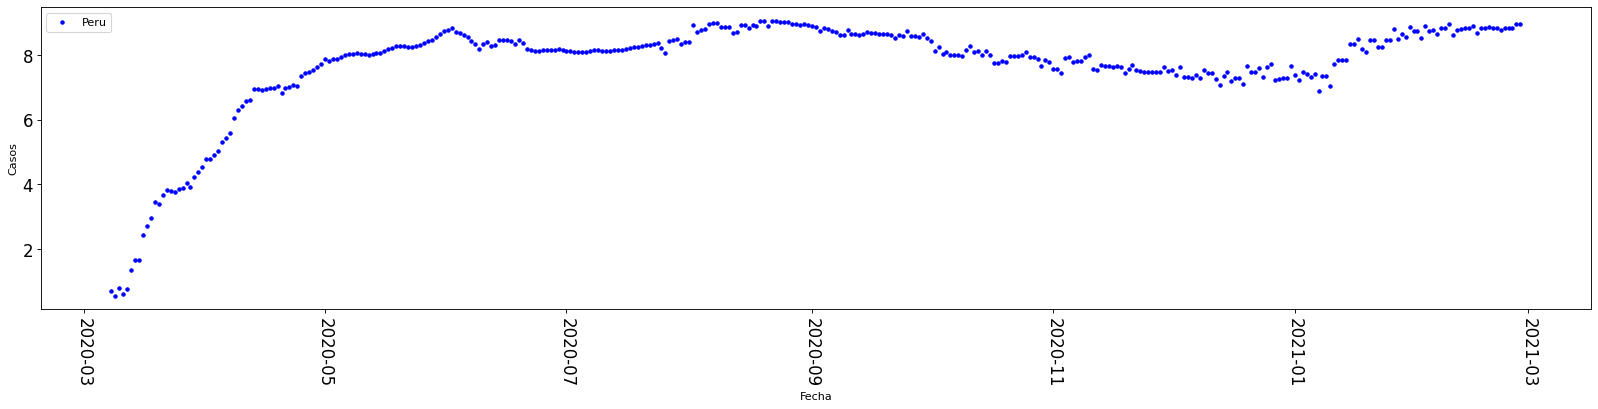

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos')

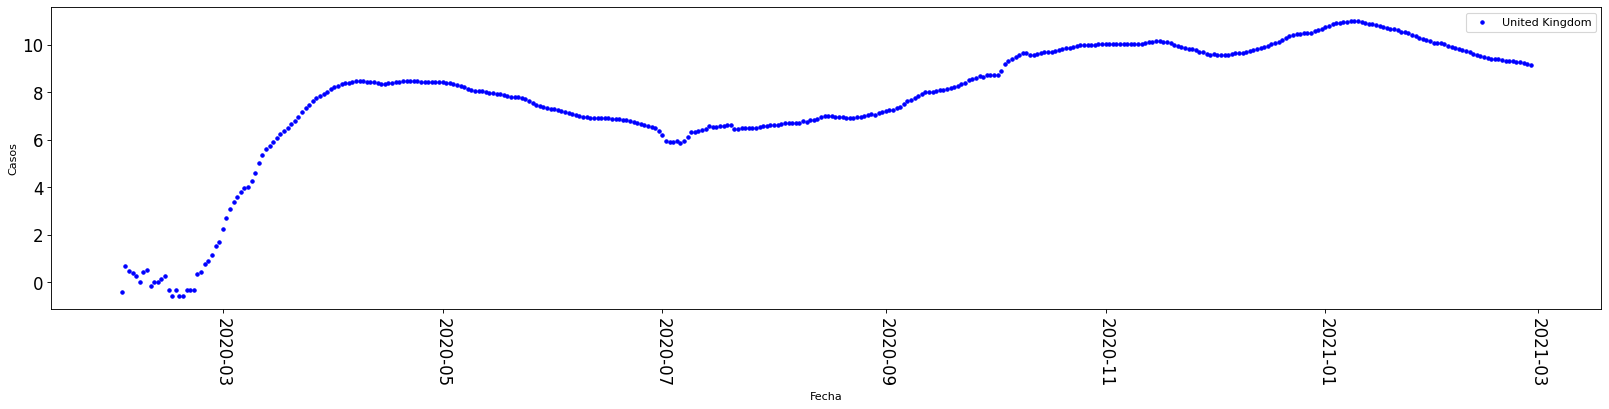

In [991]:
# Grafico por cada pais con cuarentena logaritmico

for i in paises_1:
  fig,ax = plt.subplots(figsize=(25,5), dpi= 80)
  mascara = (datos3.loc[:,'pais'] == i ) & (datos3.loc[:,'fecha'] < fechalim)
  datosconcuarentena = datos3[mascara]
  plt.plot(datosconcuarentena.fecha, np.log(datosconcuarentena.nuevos_casos), 'b.', label = i)    
  plt.xticks(rotation=-90)
  plt.xlabel('Fecha')
  plt.ylabel('Casos')
  plt.legend()
  plt.show()

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Casos promediados cada 7 días')

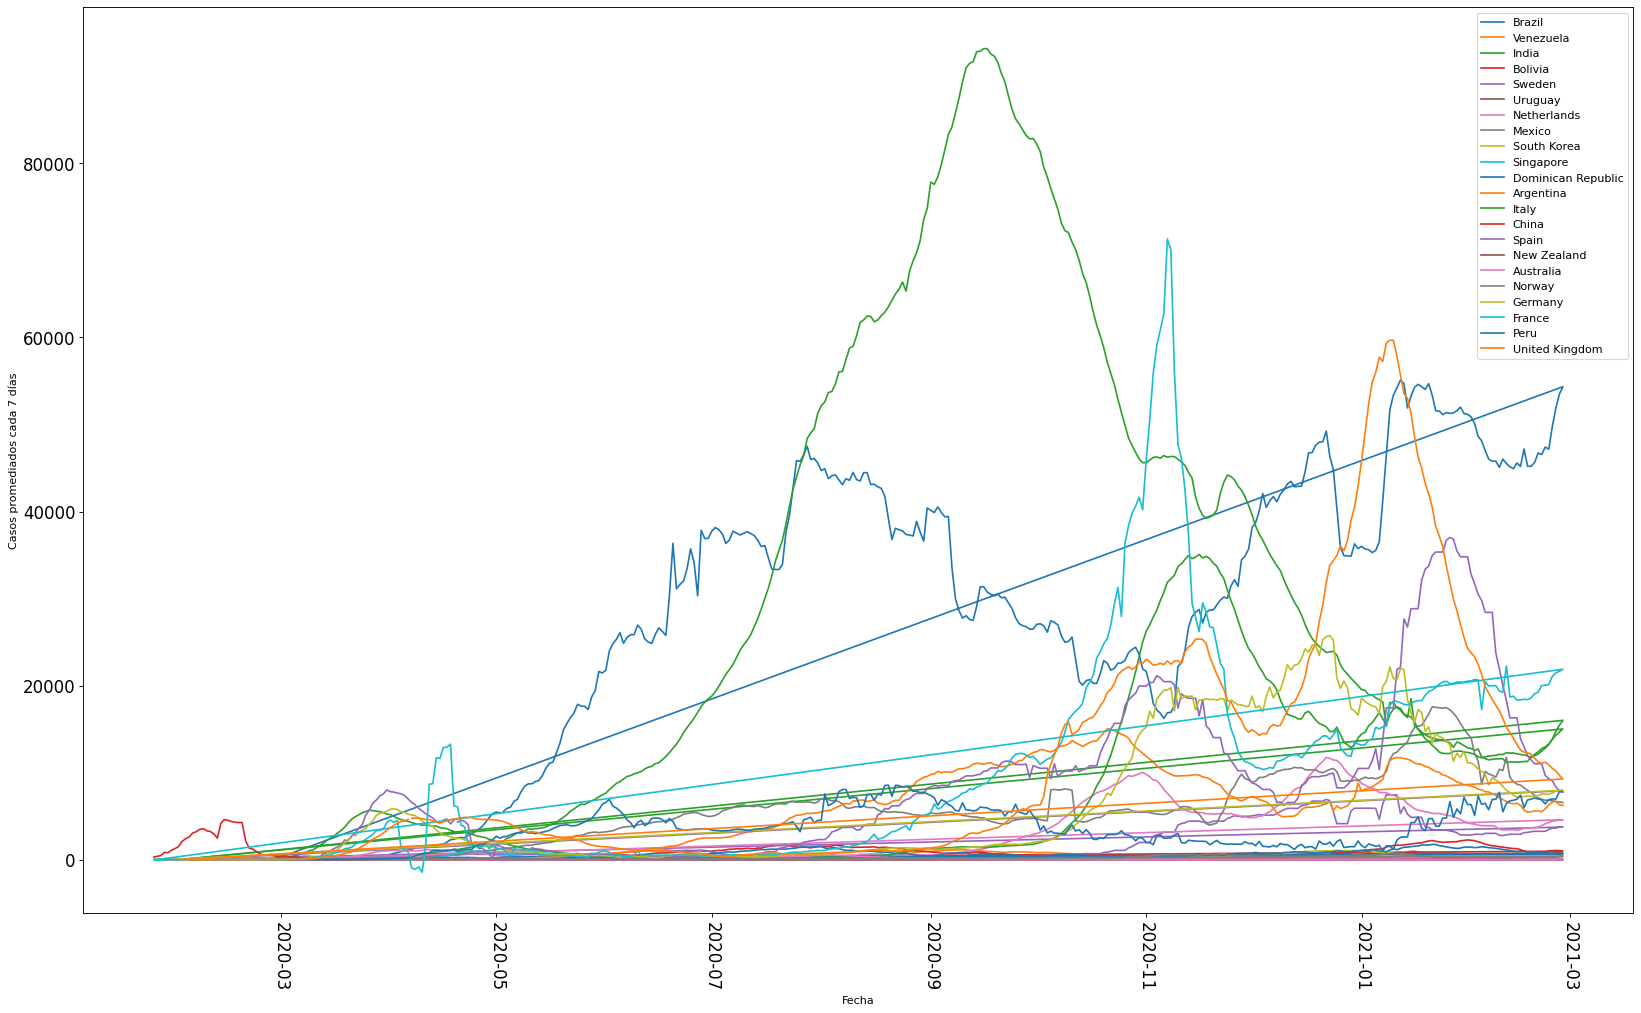

In [992]:
# Grafico todos juntos

fig,ax = plt.subplots(figsize=(25,15), dpi= 80)
for i in todos_paises:
  mascara=(datos3.loc[:,'pais'] == i ) & (datos3.loc[:,'fecha'] < fechalim)
  datagraf = datos3[mascara]  
  plt.plot(datagraf.fecha, datagraf.nuevos_casos, label = i)    
  
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Casos promediados cada 7 días')
plt.legend()
plt.show()

Para el armado del clasificador, vamos a separar dos momentos claves: El comienzo de la ola 1 y 2 y el fin de las mismas.

Por observación, se muestran los siguientes momentos:

o1_inicio = comienzo de la primer ola = 2020-03-01 al 2020-03-31

o1_fin = fin de la primer ola = 2020-04-15 al 2020-04-31

o2_inicio = comienzo segunda ola = 2020-10-01 al 2020-10-30

o2_fin = final de la segunda ola = 2020-11-15 al 2020-11-31

In [993]:
#teniendo esto, traigo nuevamente el primer dataset para poder realizar el modelo

datos=pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 4/cumulative-deaths-and-cases-covid-19.csv')
datos.rename(columns = {'Entity':'pais'}, inplace = True) 
datos.rename(columns = {'Day':'fecha'}, inplace = True) 
datos.rename(columns = {'Total confirmed cases of COVID-19'	:'casos_totales'}, inplace = True)  
datos.rename(columns = {'Total confirmed deaths due to COVID-19'	:'muertes_totales'}, inplace = True) 
datos['fecha'] = pd.to_datetime(datos.fecha)

In [994]:
#vamos a hallar las k

o1_inicio = ['2020-03-01', '2020-03-31']
o1_fin = ['2020-04-15', '2020-04-30']

o2_inicio = ['2020-10-01', '2020-10-30']
o2_fin = ['2020-11-15', '2020-11-30']

k_01_inicio = []
k_01_fin = []
k_02_inicio = []
k_02_fin = []

for i in range(len(todos_paises)):
  print(i)
  # Hallo k_01_inicio
  mascara=(datos.loc[:,'pais'] == todos_paises[i] ) & (datos.loc[:,'fecha'] >= o1_inicio[0]) & (datos.loc[:,'fecha'] <= o1_inicio[1])
  data = datos[mascara]
  y1= data.casos_totales.to_numpy()
  x1=np.arange(0,len(y1))  
  popt, pcov = curve_fit(exponencial,x1,y1,maxfev = 8000)
  k_01_inicio.append(popt[0]) 

  # Hallo k_01_fin
  mascara=(datos.loc[:,'pais'] == todos_paises[i] ) & (datos.loc[:,'fecha'] >= o1_fin[0]) & (datos.loc[:,'fecha'] <= o1_fin[1])
  data = datos[mascara]
  y2=data.casos_totales.to_numpy()
  x2=np.arange(0,len(y2))  
  popt, pcov = curve_fit(exponencial,x2,y2, maxfev = 8000)
  k_01_fin.append(popt[0]) 

  # Hallo k_02_inicio
  mascara=(datos.loc[:,'pais'] == todos_paises[i] ) & (datos.loc[:,'fecha'] >= o2_inicio[0]) & (datos.loc[:,'fecha'] <= o2_inicio[1])
  data = datos[mascara]
  y3=data.casos_totales.to_numpy()
  x3=np.arange(0,len(y3))  
  popt, pcov = curve_fit(exponencial,x3,y3, maxfev = 8000)
  k_02_inicio.append(popt[0]) 

  # Hallo k_02_fin
  mascara=(datos.loc[:,'pais'] == todos_paises[i] ) & (datos.loc[:,'fecha'] >= o2_fin[0]) & (datos.loc[:,'fecha'] <= o2_fin[1])
  data = datos[mascara]
  y4=data.casos_totales.to_numpy()
  x4=np.arange(0,len(y4))  
  popt, pcov = curve_fit(exponencial,x4,y4, maxfev = 8000)
  k_02_fin.append(popt[0])  

print(k_01_inicio)
print(k_01_fin)
print(k_02_inicio)
print(k_02_fin)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
[9.57424112350958e-07, 1.8395811048904463e-06, 0.0020138750937364926, 3.896005712760753e-06, 4.751309738944115e-06, 9.263135008276542e-06, 0.036123529752468186, 6.743851390845838e-07, 0.019013471987477625, 4.5323460738886825e-07, -0.030373387579949576, 0.04000673112295137, 0.09461234248549712, 0.0005467319048420116, 0.07561107128700387, 0.27784907394974967, 0.14612591458717192, 7.957768615300668e-07, 0.012975828816778051, 0.1338302185472812, 0.14510049144715848, 0.03802799593771048]
[0.0742434595125464, 0.03444417547153662, 0.06639945560747497, 0.0745135647305627, 0.035673972748228866, 0.018478810918885313, 0.020908166381156484, 0.07809836187982194, 0.0010891192852292481, 0.08167931622797633, 0.040069999040187716, 0.04066544207423398, 0.014168392436024028, 0.0003469831189243336, 0.009826678715018872, 0.004052098851358988, 0.0030178930822802688, 0.008878014975660981, 0.011950725242388327, 0.012331355184926845, 0.07891318319572993, 

In [995]:
# ahora que ya tengo todo los parametros armo un dataset
dat = {'Pais': todos_paises, 'k_01_inicio': k_01_inicio, 'k_01_fin': k_01_fin, 'k_02_inicio': k_02_inicio, 'k_02_fin': k_02_fin, 'y': cuarentena}
data = pd.DataFrame(dat)
data


,Pais,k_01_inicio,k_01_fin,k_02_inicio,k_02_fin,y
0,Brazil,0.0000,0.0742,0.0043,0.0054,0
1,Venezuela,0.0000,0.0344,0.0061,0.0034,0
2,India,0.0020,0.0664,0.0081,0.0047,0
3,Bolivia,0.0000,0.0745,0.0013,0.0007,0
4,Sweden,0.0000,0.0357,0.0089,0.0219,0
5,Uruguay,0.0000,0.0185,0.0142,0.0250,0
6,Netherlands,0.0361,0.0209,0.0355,0.0105,0
7,Mexico,0.0000,0.0781,0.0066,0.0074,0
8,South Korea,0.0190,0.0011,0.0034,0.0128,0
9,Singapore,0.0000,0.0817,0.0001,0.0001,0


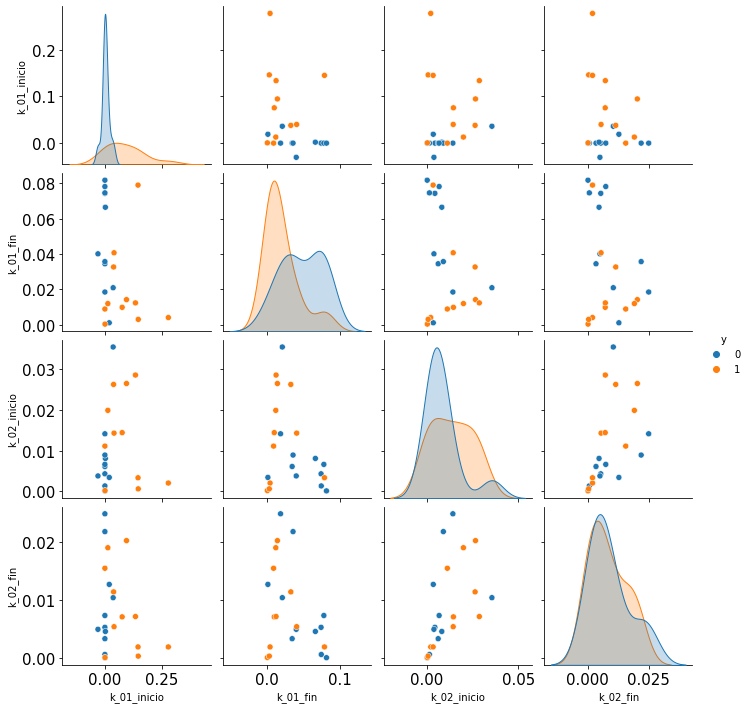

In [996]:
sns.pairplot(data= data[['k_01_inicio'	,'k_01_fin',	'k_02_inicio', 'k_02_fin',	'y']],hue = 'y')

## Machine Learning 

- Voy a usar Regresión Logística y Naive Bayes.
- Uso un accuracy del 50% como benchmark. Mis modelos van a tener que ser mejores a 50% en accuracy para ser satisfactorios.

In [997]:
## Separo mi data en X e y:
X = data[['k_01_inicio'	,'k_01_fin',	'k_02_inicio', 'k_02_fin']]
y = data[['y']] # Paises que hicieron cuarentena: 1, Paises que no hicieron cuarentena: 0.

## Separo en train y test:

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

## Naive Bayes:

nb = GaussianNB() # Benchmark para comparar contra Linear SVC y XGboost.
nb.fit(x_train,np.array(y_train).ravel())

## Regresion logistica:

logreg = LogisticRegression()
logreg.fit(x_train,y_train)


GaussianNB()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [998]:
print(x_train.shape,x_test.shape)

(15, 4) (7, 4)


In [999]:
# Defino mi matriz de confusión: 

def confusion(ytest,y_pred):
    names=["0","1"]
    cm=confusion_matrix(ytest,y_pred,normalize='true')
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",ax=ax) 
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

Gauss


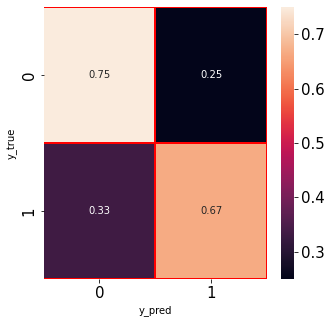

acc :  0.7142857142857143
F1 Score:  0.7083333333333333
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.67      0.67      0.67         3

    accuracy                           0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7

LogReg


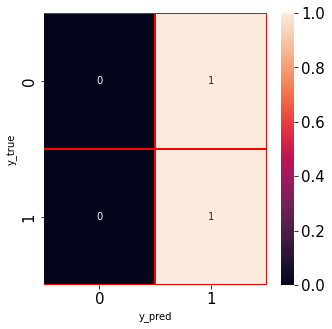

acc :  0.42857142857142855
F1 Score:  0.3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.43      1.00      0.60         3

    accuracy                           0.43         7
   macro avg       0.21      0.50      0.30         7
weighted avg       0.18      0.43      0.26         7



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1000]:
#--------
## Gauss:
#--------
print('Gauss')
y_pred_nb = nb.predict(x_test)
confusion(y_test,y_pred_nb)

print("acc : ",accuracy_score(y_test, y_pred_nb))
print("F1 Score: ", f1_score(y_test ,y_pred_nb, average='macro'))
print(classification_report(y_test, y_pred_nb))

#-----------------------
## Regresión Logistica:
#-----------------------
print('LogReg')
y_pred_logreg = logreg.predict(x_test)
confusion(y_test,y_pred_logreg)

print("acc : ",accuracy_score(y_test, y_pred_logreg))
print("F1 Score: ", f1_score(y_test ,y_pred_logreg, average='macro'))
print(classification_report(y_test, y_pred_logreg))

In [1001]:
# Ahora pruebo que pasa si aplico cross validation
cv=4
nb_scores = cross_validate(nb, X, y, cv=cv, scoring='f1_weighted',return_train_score=True)
lr_scores = cross_validate(logreg, X, y, cv=cv, scoring='f1_weighted',return_train_score=True)
clear_output()
print('***************************************')
print('Gaus')
print('Train')
print('F1 Score promedio   →',nb_scores['train_score'].mean() )
print('F1 Score desvio std →',nb_scores['train_score'].std() )


print('***************************************')
print('Regresion logistica')
print('Train')
print('F1 Score promedio   →',lr_scores['train_score'].mean() )
print('F1 Score desvio std →',lr_scores['train_score'].std() )
print('***************************************')

***************************************
Gaus
Train
F1 Score promedio   → 0.8144149967679379
F1 Score desvio std → 0.08779986848797112
***************************************
Regresion logistica
Train
F1 Score promedio   → 0.5562435500515996
F1 Score desvio std → 0.19436680846102275
***************************************


### Procedimiento y Conclusión

La idea era armar dos clasificadores y compararlos entre sí, eligiendo países que habían realizado cuarentena y aquellos que no. El método fue el mismo que la primera parte, pero tomando cuatro "momentos" (inicio y fin de las primeras 2 olas) y no sólo uno (sólo inicio de la primera).

Se armó un dataset con los resultados de las K para cada momento de cada país y en base a ello se realizó el modelo. Fiteando en train y test para el modelo Gaus y para la Regresión Logistica. Arrojando un F1 de 0.71 y 0.30 para cada uno.

El resultado no fue convincente, por lo que realicé un cross validation mejorando sólo un poco cada uno y llevando el F1 a:

- Gaus: 
F1 Score promedio   → 0.8144149967679379
F1 Score desvio std → 0.08779986848797112

- Regresión Logistica
F1 Score promedio   → 0.5562435500515996
F1 Score desvio std → 0.19436680846102275

Tanto previo como post al cross, el modelo de Gaus arroja mucho mejores resultados.

